In [1]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import lightgbm as lgb
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import label_binarize

import shap

%config InlineBackend.figure_format = 'retina'

In [2]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [3]:
df = pd.read_csv('Data/cover_type_engineered.csv')

In [4]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
X = df.drop(columns=['Cover_Type', 'Aspect_Sector'])
y = df['Cover_Type'] - 1

In [5]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the LightGBM classifier
estimator = lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y)))

# Define hyperparameters for tuning LightGBM
hyperparameters = {
    'num_leaves': stats.randint(30, 150),
    'min_child_samples': stats.randint(20, 500),
    'min_child_weight': stats.uniform(1e-5, 1e-2),
    'subsample': stats.uniform(0.5, 0.5),  
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_alpha': stats.uniform(1e-5, 1),
    'reg_lambda': stats.uniform(1e-5, 1),
    'learning_rate': stats.uniform(0.01, 0.3),
    'n_estimators': stats.randint(50, 500),
}

random_search = RandomizedSearchCV(estimator,
                                   param_distributions=hyperparameters,
                                   scoring='accuracy',  # Choose appropriate metric
                                   return_train_score=True,
                                   n_iter=500,
                                   cv=5,
                                   verbose=10,
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)

    
    # Save results
    results_path = f"./tuning_results/tuning_lgbm/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)
    
    # Save .ipynb
    copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))
    
    # Save Model
    file_name = f"lgbm_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))
    
    # random_search = pickle.load(open(file_name, "rb"))
    

except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5; 1/500] START colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912
[CV 1/5; 1/500] END colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912;, score=(train=1.000, test=0.856) total time=   6.2s
[CV 1/5; 4/500] START colsample_bytree=0.6062056232493445, learning_rate=0.2974894547758782, min_child_samples=277, min_child_weight=0.008712765129695923, n_estimators=91, num_leaves=136, reg_alpha=0.3021074899194223, reg_lambda=0.8127735491539001, subsample=0.9501615916275031
[CV 1/5; 4/500] END colsample_bytree=0.606205623249

[CV 3/5; 2/500] START colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294
[CV 3/5; 2/500] END colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294;, score=(train=0.998, test=0.857) total time=   3.9s
[CV 4/5; 2/500] START colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294
[CV 4/5; 2/500] END colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_sampl

[CV 1/5; 2/500] START colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294
[CV 1/5; 2/500] END colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294;, score=(train=0.998, test=0.857) total time=   4.1s
[CV 1/5; 3/500] START colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, min_child_weight=0.00334658941417462, n_estimators=77, num_leaves=47, reg_alpha=0.4590196133500141, reg_lambda=0.6858679287504249, subsample=0.996998505485779
[CV 1/5; 3/500] END colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=

[CV 4/5; 1/500] START colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912
[CV 4/5; 1/500] END colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912;, score=(train=1.000, test=0.863) total time=   5.7s
[CV 3/5; 3/500] START colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, min_child_weight=0.00334658941417462, n_estimators=77, num_leaves=47, reg_alpha=0.4590196133500141, reg_lambda=0.6858679287504249, subsample=0.996998505485779
[CV 3/5; 3/500] END colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, mi

[CV 2/5; 2/500] START colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294
[CV 2/5; 2/500] END colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294;, score=(train=0.997, test=0.848) total time=   4.2s
[CV 5/5; 2/500] START colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_samples=438, min_child_weight=0.00043063308326785846, n_estimators=317, num_leaves=73, reg_alpha=0.6499012319862668, reg_lambda=0.37227264404505983, subsample=0.9335210168715294
[CV 5/5; 2/500] END colsample_bytree=0.7676967674304089, learning_rate=0.1197306578497946, min_child_sampl

[CV 5/5; 1/500] START colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912
[CV 5/5; 1/500] END colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912;, score=(train=1.000, test=0.861) total time=   5.9s
[CV 5/5; 3/500] START colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, min_child_weight=0.00334658941417462, n_estimators=77, num_leaves=47, reg_alpha=0.4590196133500141, reg_lambda=0.6858679287504249, subsample=0.996998505485779
[CV 5/5; 3/500] END colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, mi

[CV 2/5; 1/500] START colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912
[CV 2/5; 1/500] END colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912;, score=(train=1.000, test=0.856) total time=   5.3s
[CV 2/5; 3/500] START colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, min_child_weight=0.00334658941417462, n_estimators=77, num_leaves=47, reg_alpha=0.4590196133500141, reg_lambda=0.6858679287504249, subsample=0.996998505485779
[CV 2/5; 3/500] END colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, mi

[CV 3/5; 1/500] START colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912
[CV 3/5; 1/500] END colsample_bytree=0.957931407341758, learning_rate=0.14798891436244344, min_child_samples=457, min_child_weight=0.008557504687892561, n_estimators=410, num_leaves=135, reg_alpha=0.593905100504062, reg_lambda=0.6546088499394438, subsample=0.8947327855022912;, score=(train=1.000, test=0.858) total time=   5.8s
[CV 4/5; 3/500] START colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, min_child_weight=0.00334658941417462, n_estimators=77, num_leaves=47, reg_alpha=0.4590196133500141, reg_lambda=0.6858679287504249, subsample=0.996998505485779
[CV 4/5; 3/500] END colsample_bytree=0.6551286221305597, learning_rate=0.024850666743911676, min_child_samples=20, mi

[CV 5/5; 40/500] START colsample_bytree=0.8734599364505662, learning_rate=0.05598963300215595, min_child_samples=430, min_child_weight=0.004426921392338019, n_estimators=173, num_leaves=67, reg_alpha=0.632649061367858, reg_lambda=0.13699575358969823, subsample=0.7745311229443803
[CV 5/5; 40/500] END colsample_bytree=0.8734599364505662, learning_rate=0.05598963300215595, min_child_samples=430, min_child_weight=0.004426921392338019, n_estimators=173, num_leaves=67, reg_alpha=0.632649061367858, reg_lambda=0.13699575358969823, subsample=0.7745311229443803;, score=(train=0.911, test=0.835) total time=   2.4s
[CV 3/5; 42/500] START colsample_bytree=0.7628475950575297, learning_rate=0.08302381144969746, min_child_samples=200, min_child_weight=0.004615096882841347, n_estimators=327, num_leaves=114, reg_alpha=0.21869860054811202, reg_lambda=0.928812047062633, subsample=0.783168057881612
[CV 3/5; 42/500] END colsample_bytree=0.7628475950575297, learning_rate=0.08302381144969746, min_child_sample

[CV 1/5; 46/500] START colsample_bytree=0.9036496265367058, learning_rate=0.1788030634392757, min_child_samples=62, min_child_weight=0.0031898085294091204, n_estimators=435, num_leaves=144, reg_alpha=0.2931126234595279, reg_lambda=0.7150895485407968, subsample=0.6525126242953998
[CV 1/5; 46/500] END colsample_bytree=0.9036496265367058, learning_rate=0.1788030634392757, min_child_samples=62, min_child_weight=0.0031898085294091204, n_estimators=435, num_leaves=144, reg_alpha=0.2931126234595279, reg_lambda=0.7150895485407968, subsample=0.6525126242953998;, score=(train=1.000, test=0.873) total time=   6.4s
[CV 3/5; 47/500] START colsample_bytree=0.5251669777723985, learning_rate=0.07940409136525177, min_child_samples=485, min_child_weight=0.0012438563127414627, n_estimators=266, num_leaves=57, reg_alpha=0.7185590070649529, reg_lambda=0.031322978756936064, subsample=0.8652126524135826
[CV 3/5; 47/500] END colsample_bytree=0.5251669777723985, learning_rate=0.07940409136525177, min_child_sam

[CV 1/5; 38/500] START colsample_bytree=0.8508291270532771, learning_rate=0.2612253351673183, min_child_samples=33, min_child_weight=0.0016482300938387873, n_estimators=387, num_leaves=75, reg_alpha=0.803598937002225, reg_lambda=0.926898721383793, subsample=0.6434576253189299
[CV 1/5; 38/500] END colsample_bytree=0.8508291270532771, learning_rate=0.2612253351673183, min_child_samples=33, min_child_weight=0.0016482300938387873, n_estimators=387, num_leaves=75, reg_alpha=0.803598937002225, reg_lambda=0.926898721383793, subsample=0.6434576253189299;, score=(train=1.000, test=0.869) total time=   3.5s
[CV 2/5; 38/500] START colsample_bytree=0.8508291270532771, learning_rate=0.2612253351673183, min_child_samples=33, min_child_weight=0.0016482300938387873, n_estimators=387, num_leaves=75, reg_alpha=0.803598937002225, reg_lambda=0.926898721383793, subsample=0.6434576253189299
[CV 2/5; 38/500] END colsample_bytree=0.8508291270532771, learning_rate=0.2612253351673183, min_child_samples=33, min_

[CV 2/5; 42/500] START colsample_bytree=0.7628475950575297, learning_rate=0.08302381144969746, min_child_samples=200, min_child_weight=0.004615096882841347, n_estimators=327, num_leaves=114, reg_alpha=0.21869860054811202, reg_lambda=0.928812047062633, subsample=0.783168057881612
[CV 2/5; 42/500] END colsample_bytree=0.7628475950575297, learning_rate=0.08302381144969746, min_child_samples=200, min_child_weight=0.004615096882841347, n_estimators=327, num_leaves=114, reg_alpha=0.21869860054811202, reg_lambda=0.928812047062633, subsample=0.783168057881612;, score=(train=1.000, test=0.855) total time=   7.1s
[CV 5/5; 43/500] START colsample_bytree=0.8719067656254069, learning_rate=0.20362390563330676, min_child_samples=197, min_child_weight=0.0049599045888755805, n_estimators=203, num_leaves=77, reg_alpha=0.4004695137410607, reg_lambda=0.4090869531999491, subsample=0.9486396870677613
[CV 5/5; 43/500] END colsample_bytree=0.8719067656254069, learning_rate=0.20362390563330676, min_child_sampl

[CV 3/5; 38/500] START colsample_bytree=0.8508291270532771, learning_rate=0.2612253351673183, min_child_samples=33, min_child_weight=0.0016482300938387873, n_estimators=387, num_leaves=75, reg_alpha=0.803598937002225, reg_lambda=0.926898721383793, subsample=0.6434576253189299
[CV 3/5; 38/500] END colsample_bytree=0.8508291270532771, learning_rate=0.2612253351673183, min_child_samples=33, min_child_weight=0.0016482300938387873, n_estimators=387, num_leaves=75, reg_alpha=0.803598937002225, reg_lambda=0.926898721383793, subsample=0.6434576253189299;, score=(train=1.000, test=0.858) total time=   3.7s
[CV 1/5; 40/500] START colsample_bytree=0.8734599364505662, learning_rate=0.05598963300215595, min_child_samples=430, min_child_weight=0.004426921392338019, n_estimators=173, num_leaves=67, reg_alpha=0.632649061367858, reg_lambda=0.13699575358969823, subsample=0.7745311229443803
[CV 1/5; 40/500] END colsample_bytree=0.8734599364505662, learning_rate=0.05598963300215595, min_child_samples=430,

[CV 1/5; 47/500] START colsample_bytree=0.5251669777723985, learning_rate=0.07940409136525177, min_child_samples=485, min_child_weight=0.0012438563127414627, n_estimators=266, num_leaves=57, reg_alpha=0.7185590070649529, reg_lambda=0.031322978756936064, subsample=0.8652126524135826
[CV 1/5; 47/500] END colsample_bytree=0.5251669777723985, learning_rate=0.07940409136525177, min_child_samples=485, min_child_weight=0.0012438563127414627, n_estimators=266, num_leaves=57, reg_alpha=0.7185590070649529, reg_lambda=0.031322978756936064, subsample=0.8652126524135826;, score=(train=0.963, test=0.846) total time=   4.3s
[CV 2/5; 48/500] START colsample_bytree=0.5978216666802256, learning_rate=0.07079043861709018, min_child_samples=305, min_child_weight=0.008253112107586382, n_estimators=365, num_leaves=76, reg_alpha=0.40022984714981175, reg_lambda=0.11565952868117517, subsample=0.5427641095206139
[CV 2/5; 48/500] END colsample_bytree=0.5978216666802256, learning_rate=0.07079043861709018, min_chil

[CV 1/5; 45/500] START colsample_bytree=0.6738569848045968, learning_rate=0.11276052111000681, min_child_samples=330, min_child_weight=0.003199503269278855, n_estimators=400, num_leaves=106, reg_alpha=0.8916118732092014, reg_lambda=0.21906854615195787, subsample=0.8799217748199548
[CV 1/5; 45/500] END colsample_bytree=0.6738569848045968, learning_rate=0.11276052111000681, min_child_samples=330, min_child_weight=0.003199503269278855, n_estimators=400, num_leaves=106, reg_alpha=0.8916118732092014, reg_lambda=0.21906854615195787, subsample=0.8799217748199548;, score=(train=1.000, test=0.860) total time=   6.5s
[CV 3/5; 46/500] START colsample_bytree=0.9036496265367058, learning_rate=0.1788030634392757, min_child_samples=62, min_child_weight=0.0031898085294091204, n_estimators=435, num_leaves=144, reg_alpha=0.2931126234595279, reg_lambda=0.7150895485407968, subsample=0.6525126242953998
[CV 3/5; 46/500] END colsample_bytree=0.9036496265367058, learning_rate=0.1788030634392757, min_child_sam

[CV 2/5; 51/500] START colsample_bytree=0.5278897871800603, learning_rate=0.1436690407823312, min_child_samples=89, min_child_weight=0.00860583554571713, n_estimators=492, num_leaves=38, reg_alpha=0.047404524285315656, reg_lambda=0.236015446170797, subsample=0.5097748412447831
[CV 2/5; 51/500] END colsample_bytree=0.5278897871800603, learning_rate=0.1436690407823312, min_child_samples=89, min_child_weight=0.00860583554571713, n_estimators=492, num_leaves=38, reg_alpha=0.047404524285315656, reg_lambda=0.236015446170797, subsample=0.5097748412447831;, score=(train=1.000, test=0.859) total time=   9.8s
[CV 1/5; 54/500] START colsample_bytree=0.8874316861697862, learning_rate=0.2413103272936853, min_child_samples=302, min_child_weight=0.003076891927557909, n_estimators=142, num_leaves=85, reg_alpha=0.5231696138812555, reg_lambda=0.5038337433977086, subsample=0.5239976258343477
[CV 1/5; 54/500] END colsample_bytree=0.8874316861697862, learning_rate=0.2413103272936853, min_child_samples=302,

[CV 4/5; 81/500] START colsample_bytree=0.8164350363674152, learning_rate=0.17635336808399768, min_child_samples=486, min_child_weight=0.005740717865035626, n_estimators=294, num_leaves=45, reg_alpha=0.37109523930075344, reg_lambda=0.5073401558801385, subsample=0.5938588200087815
[CV 4/5; 81/500] END colsample_bytree=0.8164350363674152, learning_rate=0.17635336808399768, min_child_samples=486, min_child_weight=0.005740717865035626, n_estimators=294, num_leaves=45, reg_alpha=0.37109523930075344, reg_lambda=0.5073401558801385, subsample=0.5938588200087815;, score=(train=1.000, test=0.867) total time=   4.6s
[CV 3/5; 82/500] START colsample_bytree=0.5310137764857631, learning_rate=0.13496356558371228, min_child_samples=174, min_child_weight=8.757027936986516e-05, n_estimators=80, num_leaves=36, reg_alpha=0.30690630572261873, reg_lambda=0.1363659888921161, subsample=0.869550670512462
[CV 3/5; 82/500] END colsample_bytree=0.5310137764857631, learning_rate=0.13496356558371228, min_child_samp

[CV 1/5; 83/500] START colsample_bytree=0.7288975868915906, learning_rate=0.1744027900078368, min_child_samples=71, min_child_weight=0.00405462693683433, n_estimators=82, num_leaves=48, reg_alpha=0.8572234686579703, reg_lambda=0.018403475332391218, subsample=0.9547899221004678
[CV 1/5; 83/500] END colsample_bytree=0.7288975868915906, learning_rate=0.1744027900078368, min_child_samples=71, min_child_weight=0.00405462693683433, n_estimators=82, num_leaves=48, reg_alpha=0.8572234686579703, reg_lambda=0.018403475332391218, subsample=0.9547899221004678;, score=(train=1.000, test=0.864) total time=   2.1s
[CV 4/5; 84/500] START colsample_bytree=0.7138606730843788, learning_rate=0.020847634875366196, min_child_samples=63, min_child_weight=0.009921505688903199, n_estimators=180, num_leaves=43, reg_alpha=0.5043287411275877, reg_lambda=0.8695118159844445, subsample=0.9521307830398816
[CV 4/5; 84/500] END colsample_bytree=0.7138606730843788, learning_rate=0.020847634875366196, min_child_samples=6

[CV 2/5; 87/500] START colsample_bytree=0.704003563190214, learning_rate=0.15103554373072087, min_child_samples=369, min_child_weight=0.0013820714627973086, n_estimators=141, num_leaves=142, reg_alpha=0.29178793835574773, reg_lambda=0.12128699051092888, subsample=0.5594680381550002
[CV 2/5; 87/500] END colsample_bytree=0.704003563190214, learning_rate=0.15103554373072087, min_child_samples=369, min_child_weight=0.0013820714627973086, n_estimators=141, num_leaves=142, reg_alpha=0.29178793835574773, reg_lambda=0.12128699051092888, subsample=0.5594680381550002;, score=(train=0.991, test=0.842) total time=   2.5s
[CV 5/5; 88/500] START colsample_bytree=0.697069607405108, learning_rate=0.25348250035192343, min_child_samples=299, min_child_weight=0.006128691176420704, n_estimators=208, num_leaves=73, reg_alpha=0.023363683832925575, reg_lambda=0.5947308671682745, subsample=0.849687403631706
[CV 5/5; 88/500] END colsample_bytree=0.697069607405108, learning_rate=0.25348250035192343, min_child_s

[CV 2/5; 85/500] START colsample_bytree=0.8849622591081745, learning_rate=0.25475525254701054, min_child_samples=72, min_child_weight=0.0026846679558919727, n_estimators=388, num_leaves=97, reg_alpha=0.32152038603437233, reg_lambda=0.832234180053802, subsample=0.9171580993645778
[CV 2/5; 85/500] END colsample_bytree=0.8849622591081745, learning_rate=0.25475525254701054, min_child_samples=72, min_child_weight=0.0026846679558919727, n_estimators=388, num_leaves=97, reg_alpha=0.32152038603437233, reg_lambda=0.832234180053802, subsample=0.9171580993645778;, score=(train=1.000, test=0.859) total time=   4.6s
[CV 5/5; 86/500] START colsample_bytree=0.7785577688322158, learning_rate=0.29117072217535767, min_child_samples=349, min_child_weight=0.0029632905693332723, n_estimators=115, num_leaves=59, reg_alpha=0.9483595154589219, reg_lambda=0.3058987106944006, subsample=0.547447077985072
[CV 5/5; 86/500] END colsample_bytree=0.7785577688322158, learning_rate=0.29117072217535767, min_child_sample

[CV 1/5; 80/500] START colsample_bytree=0.8622836086278619, learning_rate=0.05272720625517148, min_child_samples=192, min_child_weight=0.007595289440723765, n_estimators=455, num_leaves=32, reg_alpha=0.3374523891472771, reg_lambda=0.537770546064537, subsample=0.5068622064856163
[CV 1/5; 80/500] END colsample_bytree=0.8622836086278619, learning_rate=0.05272720625517148, min_child_samples=192, min_child_weight=0.007595289440723765, n_estimators=455, num_leaves=32, reg_alpha=0.3374523891472771, reg_lambda=0.537770546064537, subsample=0.5068622064856163;, score=(train=1.000, test=0.867) total time=  10.6s
[CV 4/5; 82/500] START colsample_bytree=0.5310137764857631, learning_rate=0.13496356558371228, min_child_samples=174, min_child_weight=8.757027936986516e-05, n_estimators=80, num_leaves=36, reg_alpha=0.30690630572261873, reg_lambda=0.1363659888921161, subsample=0.869550670512462
[CV 4/5; 82/500] END colsample_bytree=0.5310137764857631, learning_rate=0.13496356558371228, min_child_samples=

[CV 5/5; 84/500] START colsample_bytree=0.7138606730843788, learning_rate=0.020847634875366196, min_child_samples=63, min_child_weight=0.009921505688903199, n_estimators=180, num_leaves=43, reg_alpha=0.5043287411275877, reg_lambda=0.8695118159844445, subsample=0.9521307830398816
[CV 5/5; 84/500] END colsample_bytree=0.7138606730843788, learning_rate=0.020847634875366196, min_child_samples=63, min_child_weight=0.009921505688903199, n_estimators=180, num_leaves=43, reg_alpha=0.5043287411275877, reg_lambda=0.8695118159844445, subsample=0.9521307830398816;, score=(train=0.953, test=0.851) total time=   4.7s
[CV 3/5; 86/500] START colsample_bytree=0.7785577688322158, learning_rate=0.29117072217535767, min_child_samples=349, min_child_weight=0.0029632905693332723, n_estimators=115, num_leaves=59, reg_alpha=0.9483595154589219, reg_lambda=0.3058987106944006, subsample=0.547447077985072
[CV 3/5; 86/500] END colsample_bytree=0.7785577688322158, learning_rate=0.29117072217535767, min_child_sample

[CV 2/5; 96/500] START colsample_bytree=0.7603534092301765, learning_rate=0.04090663047415002, min_child_samples=458, min_child_weight=0.004884260640789983, n_estimators=240, num_leaves=80, reg_alpha=0.8165542872514863, reg_lambda=0.5587308131489795, subsample=0.7992660772733737
[CV 2/5; 96/500] END colsample_bytree=0.7603534092301765, learning_rate=0.04090663047415002, min_child_samples=458, min_child_weight=0.004884260640789983, n_estimators=240, num_leaves=80, reg_alpha=0.8165542872514863, reg_lambda=0.5587308131489795, subsample=0.7992660772733737;, score=(train=0.902, test=0.819) total time=   3.4s
[CV 5/5; 97/500] START colsample_bytree=0.6083272730529814, learning_rate=0.10269010497812514, min_child_samples=473, min_child_weight=0.0038350400271452392, n_estimators=167, num_leaves=96, reg_alpha=0.14010405437190981, reg_lambda=0.10813352105274825, subsample=0.9861926298377586
[CV 5/5; 97/500] END colsample_bytree=0.6083272730529814, learning_rate=0.10269010497812514, min_child_sam

[CV 5/5; 81/500] START colsample_bytree=0.8164350363674152, learning_rate=0.17635336808399768, min_child_samples=486, min_child_weight=0.005740717865035626, n_estimators=294, num_leaves=45, reg_alpha=0.37109523930075344, reg_lambda=0.5073401558801385, subsample=0.5938588200087815
[CV 5/5; 81/500] END colsample_bytree=0.8164350363674152, learning_rate=0.17635336808399768, min_child_samples=486, min_child_weight=0.005740717865035626, n_estimators=294, num_leaves=45, reg_alpha=0.37109523930075344, reg_lambda=0.5073401558801385, subsample=0.5938588200087815;, score=(train=1.000, test=0.854) total time=   4.2s
[CV 1/5; 84/500] START colsample_bytree=0.7138606730843788, learning_rate=0.020847634875366196, min_child_samples=63, min_child_weight=0.009921505688903199, n_estimators=180, num_leaves=43, reg_alpha=0.5043287411275877, reg_lambda=0.8695118159844445, subsample=0.9521307830398816
[CV 1/5; 84/500] END colsample_bytree=0.7138606730843788, learning_rate=0.020847634875366196, min_child_sam

[CV 4/5; 115/500] START colsample_bytree=0.9520123490035926, learning_rate=0.2781700363287552, min_child_samples=258, min_child_weight=0.009677712036748288, n_estimators=339, num_leaves=147, reg_alpha=0.9185088800730297, reg_lambda=0.4951587388328435, subsample=0.7673393093419181
[CV 4/5; 115/500] END colsample_bytree=0.9520123490035926, learning_rate=0.2781700363287552, min_child_samples=258, min_child_weight=0.009677712036748288, n_estimators=339, num_leaves=147, reg_alpha=0.9185088800730297, reg_lambda=0.4951587388328435, subsample=0.7673393093419181;, score=(train=1.000, test=0.864) total time=   3.7s
[CV 1/5; 118/500] START colsample_bytree=0.9609955258639035, learning_rate=0.24047231519123435, min_child_samples=204, min_child_weight=0.009845055694547399, n_estimators=78, num_leaves=120, reg_alpha=0.06150987409048619, reg_lambda=0.3562261061237198, subsample=0.7041926090127563
[CV 1/5; 118/500] END colsample_bytree=0.9609955258639035, learning_rate=0.24047231519123435, min_child_s

[CV 2/5; 118/500] START colsample_bytree=0.9609955258639035, learning_rate=0.24047231519123435, min_child_samples=204, min_child_weight=0.009845055694547399, n_estimators=78, num_leaves=120, reg_alpha=0.06150987409048619, reg_lambda=0.3562261061237198, subsample=0.7041926090127563
[CV 2/5; 118/500] END colsample_bytree=0.9609955258639035, learning_rate=0.24047231519123435, min_child_samples=204, min_child_weight=0.009845055694547399, n_estimators=78, num_leaves=120, reg_alpha=0.06150987409048619, reg_lambda=0.3562261061237198, subsample=0.7041926090127563;, score=(train=1.000, test=0.857) total time=   2.1s
[CV 1/5; 119/500] START colsample_bytree=0.5277622282029384, learning_rate=0.15586747255697825, min_child_samples=231, min_child_weight=0.006852680416751411, n_estimators=361, num_leaves=145, reg_alpha=0.7037314307538991, reg_lambda=0.5239333708507764, subsample=0.7739530157625367
[CV 1/5; 119/500] END colsample_bytree=0.5277622282029384, learning_rate=0.15586747255697825, min_child

[CV 2/5; 129/500] START colsample_bytree=0.5044290097313209, learning_rate=0.08068658116608846, min_child_samples=286, min_child_weight=0.003785463803095727, n_estimators=60, num_leaves=123, reg_alpha=0.05507379967682451, reg_lambda=0.5630438596181715, subsample=0.54457125971924
[CV 2/5; 129/500] END colsample_bytree=0.5044290097313209, learning_rate=0.08068658116608846, min_child_samples=286, min_child_weight=0.003785463803095727, n_estimators=60, num_leaves=123, reg_alpha=0.05507379967682451, reg_lambda=0.5630438596181715, subsample=0.54457125971924;, score=(train=0.860, test=0.803) total time=   0.9s
[CV 5/5; 129/500] START colsample_bytree=0.5044290097313209, learning_rate=0.08068658116608846, min_child_samples=286, min_child_weight=0.003785463803095727, n_estimators=60, num_leaves=123, reg_alpha=0.05507379967682451, reg_lambda=0.5630438596181715, subsample=0.54457125971924
[CV 5/5; 129/500] END colsample_bytree=0.5044290097313209, learning_rate=0.08068658116608846, min_child_sampl

[CV 5/5; 128/500] START colsample_bytree=0.8754597713791824, learning_rate=0.2736962128692452, min_child_samples=423, min_child_weight=0.0038624854044418014, n_estimators=182, num_leaves=36, reg_alpha=0.2571287629543508, reg_lambda=0.5647165608378212, subsample=0.9085660081583733
[CV 5/5; 128/500] END colsample_bytree=0.8754597713791824, learning_rate=0.2736962128692452, min_child_samples=423, min_child_weight=0.0038624854044418014, n_estimators=182, num_leaves=36, reg_alpha=0.2571287629543508, reg_lambda=0.5647165608378212, subsample=0.9085660081583733;, score=(train=1.000, test=0.861) total time=   3.0s
[CV 1/5; 131/500] START colsample_bytree=0.7398630562614732, learning_rate=0.24314504877617815, min_child_samples=150, min_child_weight=0.001247166393817617, n_estimators=195, num_leaves=137, reg_alpha=0.5007028513730603, reg_lambda=0.4743544248437999, subsample=0.7243386355120587
[CV 1/5; 131/500] END colsample_bytree=0.7398630562614732, learning_rate=0.24314504877617815, min_child_s

[CV 3/5; 129/500] START colsample_bytree=0.5044290097313209, learning_rate=0.08068658116608846, min_child_samples=286, min_child_weight=0.003785463803095727, n_estimators=60, num_leaves=123, reg_alpha=0.05507379967682451, reg_lambda=0.5630438596181715, subsample=0.54457125971924
[CV 3/5; 129/500] END colsample_bytree=0.5044290097313209, learning_rate=0.08068658116608846, min_child_samples=286, min_child_weight=0.003785463803095727, n_estimators=60, num_leaves=123, reg_alpha=0.05507379967682451, reg_lambda=0.5630438596181715, subsample=0.54457125971924;, score=(train=0.861, test=0.800) total time=   1.0s
[CV 1/5; 130/500] START colsample_bytree=0.7242399996075788, learning_rate=0.04598631723739639, min_child_samples=345, min_child_weight=0.009324190436012103, n_estimators=227, num_leaves=70, reg_alpha=0.6987320316903939, reg_lambda=0.9019901237836041, subsample=0.9457738118267139
[CV 1/5; 130/500] END colsample_bytree=0.7242399996075788, learning_rate=0.04598631723739639, min_child_samp

[CV 4/5; 124/500] START colsample_bytree=0.7349900088043059, learning_rate=0.02653076385125356, min_child_samples=152, min_child_weight=0.0030653613952904956, n_estimators=435, num_leaves=44, reg_alpha=0.29561710504316324, reg_lambda=0.48685593308862113, subsample=0.8746506069240597
[CV 4/5; 124/500] END colsample_bytree=0.7349900088043059, learning_rate=0.02653076385125356, min_child_samples=152, min_child_weight=0.0030653613952904956, n_estimators=435, num_leaves=44, reg_alpha=0.29561710504316324, reg_lambda=0.48685593308862113, subsample=0.8746506069240597;, score=(train=0.996, test=0.865) total time=  10.7s
[CV 1/5; 128/500] START colsample_bytree=0.8754597713791824, learning_rate=0.2736962128692452, min_child_samples=423, min_child_weight=0.0038624854044418014, n_estimators=182, num_leaves=36, reg_alpha=0.2571287629543508, reg_lambda=0.5647165608378212, subsample=0.9085660081583733
[CV 1/5; 128/500] END colsample_bytree=0.8754597713791824, learning_rate=0.2736962128692452, min_chi

[CV 4/5; 134/500] START colsample_bytree=0.5762637312367828, learning_rate=0.1817894145193389, min_child_samples=364, min_child_weight=0.0006322412464864636, n_estimators=357, num_leaves=136, reg_alpha=0.4865103892707319, reg_lambda=0.9172133843813661, subsample=0.6270399015301268
[CV 4/5; 134/500] END colsample_bytree=0.5762637312367828, learning_rate=0.1817894145193389, min_child_samples=364, min_child_weight=0.0006322412464864636, n_estimators=357, num_leaves=136, reg_alpha=0.4865103892707319, reg_lambda=0.9172133843813661, subsample=0.6270399015301268;, score=(train=1.000, test=0.866) total time=   6.8s
[CV 1/5; 137/500] START colsample_bytree=0.9004292625268853, learning_rate=0.1710421375606768, min_child_samples=481, min_child_weight=0.009110883151535359, n_estimators=82, num_leaves=107, reg_alpha=0.8822998919759111, reg_lambda=0.7336832725744373, subsample=0.9963316382498547
[CV 1/5; 137/500] END colsample_bytree=0.9004292625268853, learning_rate=0.1710421375606768, min_child_sa

[CV 1/5; 132/500] START colsample_bytree=0.9849880215703096, learning_rate=0.04359686805060743, min_child_samples=136, min_child_weight=0.005608097909011355, n_estimators=100, num_leaves=61, reg_alpha=0.4794428182625699, reg_lambda=0.8634509767187574, subsample=0.9285830224248032
[CV 1/5; 132/500] END colsample_bytree=0.9849880215703096, learning_rate=0.04359686805060743, min_child_samples=136, min_child_weight=0.005608097909011355, n_estimators=100, num_leaves=61, reg_alpha=0.4794428182625699, reg_lambda=0.8634509767187574, subsample=0.9285830224248032;, score=(train=0.912, test=0.830) total time=   2.3s
[CV 3/5; 133/500] START colsample_bytree=0.6774818795412185, learning_rate=0.09162290433509648, min_child_samples=480, min_child_weight=0.009003269553798482, n_estimators=497, num_leaves=126, reg_alpha=0.831433260138549, reg_lambda=0.8412920601882411, subsample=0.8643789646342244
[CV 3/5; 133/500] END colsample_bytree=0.6774818795412185, learning_rate=0.09162290433509648, min_child_sa

[CV 2/5; 160/500] START colsample_bytree=0.905196569455095, learning_rate=0.19312796292007378, min_child_samples=93, min_child_weight=0.008418504944908143, n_estimators=113, num_leaves=69, reg_alpha=0.9354748404395161, reg_lambda=0.40941277240035717, subsample=0.9388732256825887
[CV 2/5; 160/500] END colsample_bytree=0.905196569455095, learning_rate=0.19312796292007378, min_child_samples=93, min_child_weight=0.008418504944908143, n_estimators=113, num_leaves=69, reg_alpha=0.9354748404395161, reg_lambda=0.40941277240035717, subsample=0.9388732256825887;, score=(train=1.000, test=0.858) total time=   2.6s
[CV 5/5; 161/500] START colsample_bytree=0.6435544106587199, learning_rate=0.3035132591529958, min_child_samples=470, min_child_weight=0.006904951470575306, n_estimators=412, num_leaves=55, reg_alpha=0.12125765641412382, reg_lambda=0.5683876092454889, subsample=0.5468060529370855
[CV 5/5; 161/500] END colsample_bytree=0.6435544106587199, learning_rate=0.3035132591529958, min_child_sampl

[CV 5/5; 170/500] START colsample_bytree=0.687157931414623, learning_rate=0.22911380650135305, min_child_samples=37, min_child_weight=0.001003927164758265, n_estimators=316, num_leaves=116, reg_alpha=0.18552605487469392, reg_lambda=0.19502262464741288, subsample=0.9268688296653296
[CV 5/5; 170/500] END colsample_bytree=0.687157931414623, learning_rate=0.22911380650135305, min_child_samples=37, min_child_weight=0.001003927164758265, n_estimators=316, num_leaves=116, reg_alpha=0.18552605487469392, reg_lambda=0.19502262464741288, subsample=0.9268688296653296;, score=(train=1.000, test=0.871) total time=   3.9s
[CV 3/5; 172/500] START colsample_bytree=0.6341603458981475, learning_rate=0.3045734926166817, min_child_samples=75, min_child_weight=0.008089150850650914, n_estimators=117, num_leaves=47, reg_alpha=0.9600602093680414, reg_lambda=0.41627609357425016, subsample=0.7607083071528052
[CV 3/5; 172/500] END colsample_bytree=0.6341603458981475, learning_rate=0.3045734926166817, min_child_sa

[CV 3/5; 170/500] START colsample_bytree=0.687157931414623, learning_rate=0.22911380650135305, min_child_samples=37, min_child_weight=0.001003927164758265, n_estimators=316, num_leaves=116, reg_alpha=0.18552605487469392, reg_lambda=0.19502262464741288, subsample=0.9268688296653296
[CV 3/5; 170/500] END colsample_bytree=0.687157931414623, learning_rate=0.22911380650135305, min_child_samples=37, min_child_weight=0.001003927164758265, n_estimators=316, num_leaves=116, reg_alpha=0.18552605487469392, reg_lambda=0.19502262464741288, subsample=0.9268688296653296;, score=(train=1.000, test=0.867) total time=   4.2s
[CV 1/5; 172/500] START colsample_bytree=0.6341603458981475, learning_rate=0.3045734926166817, min_child_samples=75, min_child_weight=0.008089150850650914, n_estimators=117, num_leaves=47, reg_alpha=0.9600602093680414, reg_lambda=0.41627609357425016, subsample=0.7607083071528052
[CV 1/5; 172/500] END colsample_bytree=0.6341603458981475, learning_rate=0.3045734926166817, min_child_sa

[CV 4/5; 161/500] START colsample_bytree=0.6435544106587199, learning_rate=0.3035132591529958, min_child_samples=470, min_child_weight=0.006904951470575306, n_estimators=412, num_leaves=55, reg_alpha=0.12125765641412382, reg_lambda=0.5683876092454889, subsample=0.5468060529370855
[CV 4/5; 161/500] END colsample_bytree=0.6435544106587199, learning_rate=0.3035132591529958, min_child_samples=470, min_child_weight=0.006904951470575306, n_estimators=412, num_leaves=55, reg_alpha=0.12125765641412382, reg_lambda=0.5683876092454889, subsample=0.5468060529370855;, score=(train=1.000, test=0.856) total time=   6.0s
[CV 2/5; 163/500] START colsample_bytree=0.7063470523923172, learning_rate=0.2896591345144783, min_child_samples=82, min_child_weight=0.008029507344304304, n_estimators=197, num_leaves=134, reg_alpha=0.9865256245073629, reg_lambda=0.24439332502963435, subsample=0.5144961752011096
[CV 2/5; 163/500] END colsample_bytree=0.7063470523923172, learning_rate=0.2896591345144783, min_child_sam

[CV 4/5; 172/500] START colsample_bytree=0.6341603458981475, learning_rate=0.3045734926166817, min_child_samples=75, min_child_weight=0.008089150850650914, n_estimators=117, num_leaves=47, reg_alpha=0.9600602093680414, reg_lambda=0.41627609357425016, subsample=0.7607083071528052
[CV 4/5; 172/500] END colsample_bytree=0.6341603458981475, learning_rate=0.3045734926166817, min_child_samples=75, min_child_weight=0.008089150850650914, n_estimators=117, num_leaves=47, reg_alpha=0.9600602093680414, reg_lambda=0.41627609357425016, subsample=0.7607083071528052;, score=(train=1.000, test=0.856) total time=   1.9s
[CV 2/5; 173/500] START colsample_bytree=0.7906301939333649, learning_rate=0.10332810452623432, min_child_samples=47, min_child_weight=0.0024081647259729445, n_estimators=460, num_leaves=31, reg_alpha=0.7931672116255237, reg_lambda=0.14839465103433308, subsample=0.8393581725972705
[CV 2/5; 173/500] END colsample_bytree=0.7906301939333649, learning_rate=0.10332810452623432, min_child_sam

[CV 5/5; 171/500] START colsample_bytree=0.5689850583150897, learning_rate=0.07703068346003411, min_child_samples=286, min_child_weight=0.002379202664068152, n_estimators=375, num_leaves=110, reg_alpha=0.655080632628661, reg_lambda=0.9702824349894268, subsample=0.7121809672610027
[CV 5/5; 171/500] END colsample_bytree=0.5689850583150897, learning_rate=0.07703068346003411, min_child_samples=286, min_child_weight=0.002379202664068152, n_estimators=375, num_leaves=110, reg_alpha=0.655080632628661, reg_lambda=0.9702824349894268, subsample=0.7121809672610027;, score=(train=0.999, test=0.861) total time=   6.5s
[CV 2/5; 174/500] START colsample_bytree=0.9051333131345809, learning_rate=0.17228828057882495, min_child_samples=469, min_child_weight=0.008638009450841639, n_estimators=295, num_leaves=98, reg_alpha=0.7290143787920554, reg_lambda=0.7263966872546856, subsample=0.6196961883487535
[CV 2/5; 174/500] END colsample_bytree=0.9051333131345809, learning_rate=0.17228828057882495, min_child_sa

[CV 5/5; 175/500] START colsample_bytree=0.5539958742635873, learning_rate=0.14145438047764522, min_child_samples=177, min_child_weight=0.00861852787757708, n_estimators=400, num_leaves=118, reg_alpha=0.6757149897222966, reg_lambda=0.4241585706782998, subsample=0.7954167376545063
[CV 5/5; 175/500] END colsample_bytree=0.5539958742635873, learning_rate=0.14145438047764522, min_child_samples=177, min_child_weight=0.00861852787757708, n_estimators=400, num_leaves=118, reg_alpha=0.6757149897222966, reg_lambda=0.4241585706782998, subsample=0.7954167376545063;, score=(train=1.000, test=0.861) total time=   5.8s
[CV 3/5; 178/500] START colsample_bytree=0.9316693086662586, learning_rate=0.2270134379888001, min_child_samples=203, min_child_weight=0.008475787697573609, n_estimators=252, num_leaves=96, reg_alpha=0.3721701167832347, reg_lambda=0.9785449427249324, subsample=0.8308028793422007
[CV 3/5; 178/500] END colsample_bytree=0.9316693086662586, learning_rate=0.2270134379888001, min_child_samp

[CV 1/5; 207/500] START colsample_bytree=0.8095224073451135, learning_rate=0.1662443732776972, min_child_samples=38, min_child_weight=0.009646775338652082, n_estimators=180, num_leaves=62, reg_alpha=0.11687012191084827, reg_lambda=0.9610620326594894, subsample=0.8273574000250071
[CV 1/5; 207/500] END colsample_bytree=0.8095224073451135, learning_rate=0.1662443732776972, min_child_samples=38, min_child_weight=0.009646775338652082, n_estimators=180, num_leaves=62, reg_alpha=0.11687012191084827, reg_lambda=0.9610620326594894, subsample=0.8273574000250071;, score=(train=1.000, test=0.882) total time=   7.4s
[CV 4/5; 208/500] START colsample_bytree=0.5949235546862928, learning_rate=0.1211000205306338, min_child_samples=375, min_child_weight=0.0031090978149513073, n_estimators=291, num_leaves=104, reg_alpha=0.9187967131354164, reg_lambda=0.5940378489007115, subsample=0.6971147579877971
[CV 4/5; 208/500] END colsample_bytree=0.5949235546862928, learning_rate=0.1211000205306338, min_child_samp

[CV 5/5; 210/500] START colsample_bytree=0.9665925646084426, learning_rate=0.05091870329042761, min_child_samples=301, min_child_weight=0.002979386817572667, n_estimators=135, num_leaves=132, reg_alpha=0.3849866854931306, reg_lambda=0.04473021973526952, subsample=0.5668337966369938
[CV 5/5; 210/500] END colsample_bytree=0.9665925646084426, learning_rate=0.05091870329042761, min_child_samples=301, min_child_weight=0.002979386817572667, n_estimators=135, num_leaves=132, reg_alpha=0.3849866854931306, reg_lambda=0.04473021973526952, subsample=0.5668337966369938;, score=(train=0.909, test=0.836) total time=   2.9s
[CV 3/5; 212/500] START colsample_bytree=0.5109674065534118, learning_rate=0.11947635289491772, min_child_samples=359, min_child_weight=0.003511421467048156, n_estimators=68, num_leaves=71, reg_alpha=0.0626781559219755, reg_lambda=0.6476111954437079, subsample=0.9644418252296223
[CV 3/5; 212/500] END colsample_bytree=0.5109674065534118, learning_rate=0.11947635289491772, min_child

[CV 3/5; 206/500] START colsample_bytree=0.9475199519912256, learning_rate=0.137908443170376, min_child_samples=315, min_child_weight=0.006620199682596367, n_estimators=317, num_leaves=69, reg_alpha=0.41755978473833727, reg_lambda=0.22954275682148112, subsample=0.7062811080660356
[CV 3/5; 206/500] END colsample_bytree=0.9475199519912256, learning_rate=0.137908443170376, min_child_samples=315, min_child_weight=0.006620199682596367, n_estimators=317, num_leaves=69, reg_alpha=0.41755978473833727, reg_lambda=0.22954275682148112, subsample=0.7062811080660356;, score=(train=1.000, test=0.864) total time=   7.2s
[CV 1/5; 208/500] START colsample_bytree=0.5949235546862928, learning_rate=0.1211000205306338, min_child_samples=375, min_child_weight=0.0031090978149513073, n_estimators=291, num_leaves=104, reg_alpha=0.9187967131354164, reg_lambda=0.5940378489007115, subsample=0.6971147579877971
[CV 1/5; 208/500] END colsample_bytree=0.5949235546862928, learning_rate=0.1211000205306338, min_child_sa

[CV 2/5; 201/500] START colsample_bytree=0.5435497786690078, learning_rate=0.22096950796701906, min_child_samples=155, min_child_weight=0.0006483269664291957, n_estimators=176, num_leaves=91, reg_alpha=0.06530770089465558, reg_lambda=0.27843105774593574, subsample=0.8354801221580633
[CV 2/5; 201/500] END colsample_bytree=0.5435497786690078, learning_rate=0.22096950796701906, min_child_samples=155, min_child_weight=0.0006483269664291957, n_estimators=176, num_leaves=91, reg_alpha=0.06530770089465558, reg_lambda=0.27843105774593574, subsample=0.8354801221580633;, score=(train=1.000, test=0.854) total time=   4.0s
[CV 1/5; 202/500] START colsample_bytree=0.6625552964039407, learning_rate=0.2743827131787218, min_child_samples=468, min_child_weight=0.003377919707711825, n_estimators=499, num_leaves=117, reg_alpha=0.552558307121524, reg_lambda=0.10558411247229842, subsample=0.7079509376141688
[CV 1/5; 202/500] END colsample_bytree=0.6625552964039407, learning_rate=0.2743827131787218, min_chi

[CV 5/5; 209/500] START colsample_bytree=0.7053816337067804, learning_rate=0.19965488174404736, min_child_samples=98, min_child_weight=0.0024804954942461922, n_estimators=330, num_leaves=88, reg_alpha=0.9704076503701686, reg_lambda=0.3170983352391546, subsample=0.8287769677927805
[CV 5/5; 209/500] END colsample_bytree=0.7053816337067804, learning_rate=0.19965488174404736, min_child_samples=98, min_child_weight=0.0024804954942461922, n_estimators=330, num_leaves=88, reg_alpha=0.9704076503701686, reg_lambda=0.3170983352391546, subsample=0.8287769677927805;, score=(train=1.000, test=0.864) total time=   4.4s
[CV 3/5; 211/500] START colsample_bytree=0.9174391242781813, learning_rate=0.1551767540951184, min_child_samples=97, min_child_weight=0.00855678769759751, n_estimators=159, num_leaves=40, reg_alpha=0.510350420897523, reg_lambda=0.21769332411082293, subsample=0.6242950674184478
[CV 3/5; 211/500] END colsample_bytree=0.9174391242781813, learning_rate=0.1551767540951184, min_child_sample

[CV 2/5; 203/500] START colsample_bytree=0.8172975443326604, learning_rate=0.06838099889150953, min_child_samples=140, min_child_weight=0.008882979437929114, n_estimators=482, num_leaves=118, reg_alpha=0.768857023539444, reg_lambda=0.4334804726367572, subsample=0.8327437296370335
[CV 2/5; 203/500] END colsample_bytree=0.8172975443326604, learning_rate=0.06838099889150953, min_child_samples=140, min_child_weight=0.008882979437929114, n_estimators=482, num_leaves=118, reg_alpha=0.768857023539444, reg_lambda=0.4334804726367572, subsample=0.8327437296370335;, score=(train=1.000, test=0.860) total time=  12.6s
[CV 5/5; 204/500] START colsample_bytree=0.8456174970520607, learning_rate=0.1840358855229132, min_child_samples=310, min_child_weight=0.005765886211505455, n_estimators=474, num_leaves=79, reg_alpha=0.06287349153377723, reg_lambda=0.6992426887028254, subsample=0.5494237411347265
[CV 5/5; 204/500] END colsample_bytree=0.8456174970520607, learning_rate=0.1840358855229132, min_child_sam

[CV 4/5; 221/500] START colsample_bytree=0.8946855800458897, learning_rate=0.06983430444170527, min_child_samples=112, min_child_weight=0.0031379279815327687, n_estimators=102, num_leaves=114, reg_alpha=0.012643647960389238, reg_lambda=0.4061699717587907, subsample=0.8598311021673839
[CV 4/5; 221/500] END colsample_bytree=0.8946855800458897, learning_rate=0.06983430444170527, min_child_samples=112, min_child_weight=0.0031379279815327687, n_estimators=102, num_leaves=114, reg_alpha=0.012643647960389238, reg_lambda=0.4061699717587907, subsample=0.8598311021673839;, score=(train=0.988, test=0.865) total time=   2.8s
[CV 2/5; 222/500] START colsample_bytree=0.8285001611907301, learning_rate=0.21585456726973246, min_child_samples=103, min_child_weight=0.0015501648855887806, n_estimators=437, num_leaves=48, reg_alpha=0.9275998836423212, reg_lambda=0.8140636272364334, subsample=0.7899027656527113
[CV 2/5; 222/500] END colsample_bytree=0.8285001611907301, learning_rate=0.21585456726973246, min

[CV 3/5; 219/500] START colsample_bytree=0.8344714215110027, learning_rate=0.24207583842078195, min_child_samples=109, min_child_weight=0.0031029174895719058, n_estimators=267, num_leaves=135, reg_alpha=0.6336988772383046, reg_lambda=0.7760311713646569, subsample=0.7859955172944293
[CV 3/5; 219/500] END colsample_bytree=0.8344714215110027, learning_rate=0.24207583842078195, min_child_samples=109, min_child_weight=0.0031029174895719058, n_estimators=267, num_leaves=135, reg_alpha=0.6336988772383046, reg_lambda=0.7760311713646569, subsample=0.7859955172944293;, score=(train=1.000, test=0.864) total time=   4.5s
[CV 1/5; 220/500] START colsample_bytree=0.7937957227440843, learning_rate=0.14215960010251094, min_child_samples=35, min_child_weight=0.005306052079362162, n_estimators=371, num_leaves=74, reg_alpha=0.6860431755638139, reg_lambda=0.4471865577901725, subsample=0.85157327503563
[CV 1/5; 220/500] END colsample_bytree=0.7937957227440843, learning_rate=0.14215960010251094, min_child_s

[CV 5/5; 249/500] START colsample_bytree=0.6757179474735819, learning_rate=0.20163403195907756, min_child_samples=156, min_child_weight=0.009015651380531401, n_estimators=82, num_leaves=102, reg_alpha=0.4138161245282784, reg_lambda=0.05878730098382772, subsample=0.9258276741019795
[CV 5/5; 249/500] END colsample_bytree=0.6757179474735819, learning_rate=0.20163403195907756, min_child_samples=156, min_child_weight=0.009015651380531401, n_estimators=82, num_leaves=102, reg_alpha=0.4138161245282784, reg_lambda=0.05878730098382772, subsample=0.9258276741019795;, score=(train=1.000, test=0.864) total time=   1.9s
[CV 3/5; 250/500] START colsample_bytree=0.8300916344043724, learning_rate=0.28482824109249066, min_child_samples=348, min_child_weight=0.006029086462682034, n_estimators=228, num_leaves=106, reg_alpha=0.6027212681454426, reg_lambda=0.37345032609911594, subsample=0.8540064382055021
[CV 3/5; 250/500] END colsample_bytree=0.8300916344043724, learning_rate=0.28482824109249066, min_chil

[CV 4/5; 243/500] START colsample_bytree=0.9954061173851145, learning_rate=0.07887641612977442, min_child_samples=277, min_child_weight=0.006341301515210152, n_estimators=374, num_leaves=109, reg_alpha=0.007174530686782466, reg_lambda=0.7941268990051817, subsample=0.6921451879229273
[CV 4/5; 243/500] END colsample_bytree=0.9954061173851145, learning_rate=0.07887641612977442, min_child_samples=277, min_child_weight=0.006341301515210152, n_estimators=374, num_leaves=109, reg_alpha=0.007174530686782466, reg_lambda=0.7941268990051817, subsample=0.6921451879229273;, score=(train=1.000, test=0.866) total time=   8.6s
[CV 4/5; 245/500] START colsample_bytree=0.9821536032656542, learning_rate=0.29841722875216753, min_child_samples=470, min_child_weight=0.009278207507978836, n_estimators=475, num_leaves=124, reg_alpha=0.5689462327220725, reg_lambda=0.8910686031191035, subsample=0.8350935443785654
[CV 4/5; 245/500] END colsample_bytree=0.9821536032656542, learning_rate=0.29841722875216753, min_c

[CV 3/5; 245/500] START colsample_bytree=0.9821536032656542, learning_rate=0.29841722875216753, min_child_samples=470, min_child_weight=0.009278207507978836, n_estimators=475, num_leaves=124, reg_alpha=0.5689462327220725, reg_lambda=0.8910686031191035, subsample=0.8350935443785654
[CV 3/5; 245/500] END colsample_bytree=0.9821536032656542, learning_rate=0.29841722875216753, min_child_samples=470, min_child_weight=0.009278207507978836, n_estimators=475, num_leaves=124, reg_alpha=0.5689462327220725, reg_lambda=0.8910686031191035, subsample=0.8350935443785654;, score=(train=1.000, test=0.859) total time=   5.8s
[CV 1/5; 247/500] START colsample_bytree=0.98611909486529, learning_rate=0.07962450210768314, min_child_samples=477, min_child_weight=0.001562853446543555, n_estimators=78, num_leaves=50, reg_alpha=0.2570074609639335, reg_lambda=0.48476170345663455, subsample=0.8527160882060811
[CV 1/5; 247/500] END colsample_bytree=0.98611909486529, learning_rate=0.07962450210768314, min_child_samp

[CV 3/5; 249/500] START colsample_bytree=0.6757179474735819, learning_rate=0.20163403195907756, min_child_samples=156, min_child_weight=0.009015651380531401, n_estimators=82, num_leaves=102, reg_alpha=0.4138161245282784, reg_lambda=0.05878730098382772, subsample=0.9258276741019795
[CV 3/5; 249/500] END colsample_bytree=0.6757179474735819, learning_rate=0.20163403195907756, min_child_samples=156, min_child_weight=0.009015651380531401, n_estimators=82, num_leaves=102, reg_alpha=0.4138161245282784, reg_lambda=0.05878730098382772, subsample=0.9258276741019795;, score=(train=1.000, test=0.859) total time=   2.0s
[CV 1/5; 250/500] START colsample_bytree=0.8300916344043724, learning_rate=0.28482824109249066, min_child_samples=348, min_child_weight=0.006029086462682034, n_estimators=228, num_leaves=106, reg_alpha=0.6027212681454426, reg_lambda=0.37345032609911594, subsample=0.8540064382055021
[CV 1/5; 250/500] END colsample_bytree=0.8300916344043724, learning_rate=0.28482824109249066, min_chil

[CV 5/5; 250/500] START colsample_bytree=0.8300916344043724, learning_rate=0.28482824109249066, min_child_samples=348, min_child_weight=0.006029086462682034, n_estimators=228, num_leaves=106, reg_alpha=0.6027212681454426, reg_lambda=0.37345032609911594, subsample=0.8540064382055021
[CV 5/5; 250/500] END colsample_bytree=0.8300916344043724, learning_rate=0.28482824109249066, min_child_samples=348, min_child_weight=0.006029086462682034, n_estimators=228, num_leaves=106, reg_alpha=0.6027212681454426, reg_lambda=0.37345032609911594, subsample=0.8540064382055021;, score=(train=1.000, test=0.859) total time=   3.7s
[CV 4/5; 252/500] START colsample_bytree=0.82777621394164, learning_rate=0.0894467622038996, min_child_samples=333, min_child_weight=0.000802985491420496, n_estimators=127, num_leaves=54, reg_alpha=0.3943110799973136, reg_lambda=0.12927216497669386, subsample=0.8313671061091257
[CV 4/5; 252/500] END colsample_bytree=0.82777621394164, learning_rate=0.0894467622038996, min_child_sam

[CV 2/5; 254/500] START colsample_bytree=0.852108965417933, learning_rate=0.014555922166870064, min_child_samples=211, min_child_weight=0.006374413041276099, n_estimators=314, num_leaves=135, reg_alpha=0.49612842029901344, reg_lambda=0.3452986976855577, subsample=0.8536376026170637
[CV 2/5; 254/500] END colsample_bytree=0.852108965417933, learning_rate=0.014555922166870064, min_child_samples=211, min_child_weight=0.006374413041276099, n_estimators=314, num_leaves=135, reg_alpha=0.49612842029901344, reg_lambda=0.3452986976855577, subsample=0.8536376026170637;, score=(train=0.884, test=0.812) total time=   5.4s
[CV 5/5; 254/500] START colsample_bytree=0.852108965417933, learning_rate=0.014555922166870064, min_child_samples=211, min_child_weight=0.006374413041276099, n_estimators=314, num_leaves=135, reg_alpha=0.49612842029901344, reg_lambda=0.3452986976855577, subsample=0.8536376026170637
[CV 5/5; 254/500] END colsample_bytree=0.852108965417933, learning_rate=0.014555922166870064, min_ch

[CV 3/5; 261/500] START colsample_bytree=0.6873654917353967, learning_rate=0.2227634329000757, min_child_samples=250, min_child_weight=0.0007448160972874896, n_estimators=312, num_leaves=59, reg_alpha=0.22090530929594393, reg_lambda=0.6547521410971602, subsample=0.8795600659534668
[CV 3/5; 261/500] END colsample_bytree=0.6873654917353967, learning_rate=0.2227634329000757, min_child_samples=250, min_child_weight=0.0007448160972874896, n_estimators=312, num_leaves=59, reg_alpha=0.22090530929594393, reg_lambda=0.6547521410971602, subsample=0.8795600659534668;, score=(train=1.000, test=0.869) total time=   5.5s
[CV 2/5; 263/500] START colsample_bytree=0.5337326213504696, learning_rate=0.27122800687901105, min_child_samples=495, min_child_weight=0.002623257112151666, n_estimators=356, num_leaves=68, reg_alpha=0.363583774150067, reg_lambda=0.6884546024944604, subsample=0.5533175462693324
[CV 2/5; 263/500] END colsample_bytree=0.5337326213504696, learning_rate=0.27122800687901105, min_child_s

[CV 1/5; 262/500] START colsample_bytree=0.669170842716902, learning_rate=0.15896280498136026, min_child_samples=229, min_child_weight=0.007405341552940636, n_estimators=122, num_leaves=112, reg_alpha=0.34765418157969313, reg_lambda=0.6550630651807194, subsample=0.871782355547444
[CV 1/5; 262/500] END colsample_bytree=0.669170842716902, learning_rate=0.15896280498136026, min_child_samples=229, min_child_weight=0.007405341552940636, n_estimators=122, num_leaves=112, reg_alpha=0.34765418157969313, reg_lambda=0.6550630651807194, subsample=0.871782355547444;, score=(train=0.998, test=0.859) total time=   2.5s
[CV 3/5; 262/500] START colsample_bytree=0.669170842716902, learning_rate=0.15896280498136026, min_child_samples=229, min_child_weight=0.007405341552940636, n_estimators=122, num_leaves=112, reg_alpha=0.34765418157969313, reg_lambda=0.6550630651807194, subsample=0.871782355547444
[CV 3/5; 262/500] END colsample_bytree=0.669170842716902, learning_rate=0.15896280498136026, min_child_sam

[CV 1/5; 284/500] START colsample_bytree=0.967963686335975, learning_rate=0.03195365083978903, min_child_samples=344, min_child_weight=0.002466618665449959, n_estimators=243, num_leaves=35, reg_alpha=0.3514424177657151, reg_lambda=0.11264183664491738, subsample=0.7910245526837681
[CV 1/5; 284/500] END colsample_bytree=0.967963686335975, learning_rate=0.03195365083978903, min_child_samples=344, min_child_weight=0.002466618665449959, n_estimators=243, num_leaves=35, reg_alpha=0.3514424177657151, reg_lambda=0.11264183664491738, subsample=0.7910245526837681;, score=(train=0.912, test=0.828) total time=   4.0s
[CV 1/5; 285/500] START colsample_bytree=0.5699262625739138, learning_rate=0.09577336496253232, min_child_samples=271, min_child_weight=0.004369416453616703, n_estimators=312, num_leaves=81, reg_alpha=0.45284477381474114, reg_lambda=0.005693111088970682, subsample=0.7122313103663873
[CV 1/5; 285/500] END colsample_bytree=0.5699262625739138, learning_rate=0.09577336496253232, min_child

[CV 5/5; 286/500] START colsample_bytree=0.8961383413977316, learning_rate=0.25691120200620293, min_child_samples=192, min_child_weight=0.005349689714755664, n_estimators=87, num_leaves=116, reg_alpha=0.8151337005715779, reg_lambda=0.9977751254302235, subsample=0.6277211108712151
[CV 5/5; 286/500] END colsample_bytree=0.8961383413977316, learning_rate=0.25691120200620293, min_child_samples=192, min_child_weight=0.005349689714755664, n_estimators=87, num_leaves=116, reg_alpha=0.8151337005715779, reg_lambda=0.9977751254302235, subsample=0.6277211108712151;, score=(train=1.000, test=0.861) total time=   1.8s
[CV 1/5; 288/500] START colsample_bytree=0.5644219799352541, learning_rate=0.1511251393536128, min_child_samples=383, min_child_weight=0.00626954525309209, n_estimators=55, num_leaves=131, reg_alpha=0.03248772834017171, reg_lambda=0.49428236604977077, subsample=0.7345826002235989
[CV 1/5; 288/500] END colsample_bytree=0.5644219799352541, learning_rate=0.1511251393536128, min_child_sam

[CV 5/5; 320/500] END colsample_bytree=0.7789053960788151, learning_rate=0.12162194777715413, min_child_samples=199, min_child_weight=0.0006264575070288392, n_estimators=481, num_leaves=34, reg_alpha=0.16219362783853913, reg_lambda=0.8711248589024071, subsample=0.5039164674879484;, score=(train=1.000, test=0.864) total time=  10.3s
[CV 1/5; 324/500] START colsample_bytree=0.9679181812963098, learning_rate=0.05223984667814763, min_child_samples=367, min_child_weight=0.005658070288380902, n_estimators=230, num_leaves=62, reg_alpha=0.09972577632034978, reg_lambda=0.07140792328008631, subsample=0.9972716394330415
[CV 1/5; 324/500] END colsample_bytree=0.9679181812963098, learning_rate=0.05223984667814763, min_child_samples=367, min_child_weight=0.005658070288380902, n_estimators=230, num_leaves=62, reg_alpha=0.09972577632034978, reg_lambda=0.07140792328008631, subsample=0.9972716394330415;, score=(train=0.956, test=0.844) total time=   4.1s
[CV 4/5; 324/500] START colsample_bytree=0.967918

[CV 3/5; 291/500] START colsample_bytree=0.5147393417692214, learning_rate=0.28811399286201334, min_child_samples=313, min_child_weight=0.006070318265573825, n_estimators=152, num_leaves=126, reg_alpha=0.6729982422067837, reg_lambda=0.5810901013267586, subsample=0.7477686722983473
[CV 3/5; 291/500] END colsample_bytree=0.5147393417692214, learning_rate=0.28811399286201334, min_child_samples=313, min_child_weight=0.006070318265573825, n_estimators=152, num_leaves=126, reg_alpha=0.6729982422067837, reg_lambda=0.5810901013267586, subsample=0.7477686722983473;, score=(train=1.000, test=0.854) total time=   2.5s
[CV 4/5; 292/500] START colsample_bytree=0.5685330346317821, learning_rate=0.08199199318895645, min_child_samples=152, min_child_weight=0.009248925965604225, n_estimators=458, num_leaves=61, reg_alpha=0.4757341142446812, reg_lambda=0.09352513344407469, subsample=0.6903394043935358
[CV 4/5; 292/500] END colsample_bytree=0.5685330346317821, learning_rate=0.08199199318895645, min_child

[CV 3/5; 292/500] START colsample_bytree=0.5685330346317821, learning_rate=0.08199199318895645, min_child_samples=152, min_child_weight=0.009248925965604225, n_estimators=458, num_leaves=61, reg_alpha=0.4757341142446812, reg_lambda=0.09352513344407469, subsample=0.6903394043935358
[CV 3/5; 292/500] END colsample_bytree=0.5685330346317821, learning_rate=0.08199199318895645, min_child_samples=152, min_child_weight=0.009248925965604225, n_estimators=458, num_leaves=61, reg_alpha=0.4757341142446812, reg_lambda=0.09352513344407469, subsample=0.6903394043935358;, score=(train=1.000, test=0.866) total time=   9.5s
[CV 4/5; 294/500] START colsample_bytree=0.6727408009311618, learning_rate=0.1922966958305112, min_child_samples=32, min_child_weight=0.004789434847840795, n_estimators=99, num_leaves=36, reg_alpha=0.4831673342528559, reg_lambda=0.20453485277057687, subsample=0.9418879222444302
[CV 4/5; 294/500] END colsample_bytree=0.6727408009311618, learning_rate=0.1922966958305112, min_child_sam

[CV 1/5; 295/500] START colsample_bytree=0.7797980907083628, learning_rate=0.07612012836039972, min_child_samples=210, min_child_weight=0.005478757338587489, n_estimators=492, num_leaves=60, reg_alpha=0.38902237868943407, reg_lambda=0.7129472066824605, subsample=0.7194821593062071
[CV 1/5; 295/500] END colsample_bytree=0.7797980907083628, learning_rate=0.07612012836039972, min_child_samples=210, min_child_weight=0.005478757338587489, n_estimators=492, num_leaves=60, reg_alpha=0.38902237868943407, reg_lambda=0.7129472066824605, subsample=0.7194821593062071;, score=(train=1.000, test=0.867) total time=  10.8s
[CV 2/5; 297/500] START colsample_bytree=0.5982197778637776, learning_rate=0.048124617798371384, min_child_samples=390, min_child_weight=0.0016031367076528602, n_estimators=154, num_leaves=87, reg_alpha=0.49727963321213137, reg_lambda=0.6039360495219032, subsample=0.5269943911140348
[CV 2/5; 297/500] END colsample_bytree=0.5982197778637776, learning_rate=0.048124617798371384, min_ch

[CV 4/5; 302/500] START colsample_bytree=0.9891209778577479, learning_rate=0.04552809856942476, min_child_samples=456, min_child_weight=0.004561302104125104, n_estimators=234, num_leaves=130, reg_alpha=0.4819466054330997, reg_lambda=0.8278545529691458, subsample=0.9933433868187181
[CV 4/5; 302/500] END colsample_bytree=0.9891209778577479, learning_rate=0.04552809856942476, min_child_samples=456, min_child_weight=0.004561302104125104, n_estimators=234, num_leaves=130, reg_alpha=0.4819466054330997, reg_lambda=0.8278545529691458, subsample=0.9933433868187181;, score=(train=0.920, test=0.846) total time=   4.3s
[CV 3/5; 304/500] START colsample_bytree=0.8146152467463068, learning_rate=0.06553563493237435, min_child_samples=443, min_child_weight=0.005534712643974883, n_estimators=144, num_leaves=128, reg_alpha=0.6168896566315158, reg_lambda=0.12827714075939195, subsample=0.8837811475330984
[CV 3/5; 304/500] END colsample_bytree=0.8146152467463068, learning_rate=0.06553563493237435, min_chil

[CV 4/5; 301/500] START colsample_bytree=0.9386155052123827, learning_rate=0.06396032905048307, min_child_samples=491, min_child_weight=0.004641862190866867, n_estimators=408, num_leaves=43, reg_alpha=0.510005243193735, reg_lambda=0.7406219489793465, subsample=0.8061272093912103
[CV 4/5; 301/500] END colsample_bytree=0.9386155052123827, learning_rate=0.06396032905048307, min_child_samples=491, min_child_weight=0.004641862190866867, n_estimators=408, num_leaves=43, reg_alpha=0.510005243193735, reg_lambda=0.7406219489793465, subsample=0.8061272093912103;, score=(train=0.984, test=0.859) total time=   7.4s
[CV 5/5; 303/500] START colsample_bytree=0.6525957513089585, learning_rate=0.2696433100393436, min_child_samples=485, min_child_weight=0.004266519102098869, n_estimators=475, num_leaves=53, reg_alpha=0.03213172610646802, reg_lambda=0.3240398645862194, subsample=0.8190654743438548
[CV 5/5; 303/500] END colsample_bytree=0.6525957513089585, learning_rate=0.2696433100393436, min_child_sampl

[CV 1/5; 322/500] START colsample_bytree=0.820774242823382, learning_rate=0.30761929478864186, min_child_samples=179, min_child_weight=0.005230740824543788, n_estimators=297, num_leaves=112, reg_alpha=0.1871438505865129, reg_lambda=0.6644322292307329, subsample=0.698298390621579
[CV 1/5; 322/500] END colsample_bytree=0.820774242823382, learning_rate=0.30761929478864186, min_child_samples=179, min_child_weight=0.005230740824543788, n_estimators=297, num_leaves=112, reg_alpha=0.1871438505865129, reg_lambda=0.6644322292307329, subsample=0.698298390621579;, score=(train=1.000, test=0.866) total time=   4.5s
[CV 4/5; 322/500] START colsample_bytree=0.820774242823382, learning_rate=0.30761929478864186, min_child_samples=179, min_child_weight=0.005230740824543788, n_estimators=297, num_leaves=112, reg_alpha=0.1871438505865129, reg_lambda=0.6644322292307329, subsample=0.698298390621579
[CV 4/5; 322/500] END colsample_bytree=0.820774242823382, learning_rate=0.30761929478864186, min_child_sample

[CV 1/5; 329/500] START colsample_bytree=0.8312521109982878, learning_rate=0.024202024387730947, min_child_samples=278, min_child_weight=0.0005143121439750587, n_estimators=252, num_leaves=40, reg_alpha=0.6611861397367851, reg_lambda=0.6601924465163241, subsample=0.5285560485696972
[CV 1/5; 329/500] END colsample_bytree=0.8312521109982878, learning_rate=0.024202024387730947, min_child_samples=278, min_child_weight=0.0005143121439750587, n_estimators=252, num_leaves=40, reg_alpha=0.6611861397367851, reg_lambda=0.6601924465163241, subsample=0.5285560485696972;, score=(train=0.891, test=0.815) total time=   4.7s
[CV 2/5; 330/500] START colsample_bytree=0.7047639240137723, learning_rate=0.24691002149190047, min_child_samples=374, min_child_weight=0.007698662405701463, n_estimators=475, num_leaves=71, reg_alpha=0.6681368436986268, reg_lambda=0.06635085499724751, subsample=0.626775983296926
[CV 2/5; 330/500] END colsample_bytree=0.7047639240137723, learning_rate=0.24691002149190047, min_chil

[CV 1/5; 327/500] START colsample_bytree=0.7696585319528115, learning_rate=0.07494056282332034, min_child_samples=68, min_child_weight=0.009661525877577685, n_estimators=411, num_leaves=105, reg_alpha=0.8709298182496721, reg_lambda=0.04721656141861235, subsample=0.8342295942833476
[CV 1/5; 327/500] END colsample_bytree=0.7696585319528115, learning_rate=0.07494056282332034, min_child_samples=68, min_child_weight=0.009661525877577685, n_estimators=411, num_leaves=105, reg_alpha=0.8709298182496721, reg_lambda=0.04721656141861235, subsample=0.8342295942833476;, score=(train=1.000, test=0.876) total time=   7.7s
[CV 4/5; 328/500] START colsample_bytree=0.8802702003857508, learning_rate=0.13013345867609377, min_child_samples=199, min_child_weight=0.00779988889783042, n_estimators=380, num_leaves=136, reg_alpha=0.06032040357634166, reg_lambda=0.22549358417846793, subsample=0.5822058411813882
[CV 4/5; 328/500] END colsample_bytree=0.8802702003857508, learning_rate=0.13013345867609377, min_chil

[CV 5/5; 336/500] START colsample_bytree=0.5625374261817735, learning_rate=0.24985460020789696, min_child_samples=442, min_child_weight=0.009860280070306203, n_estimators=63, num_leaves=72, reg_alpha=0.15325194590673014, reg_lambda=0.8803990419568257, subsample=0.8712572696377512
[CV 5/5; 336/500] END colsample_bytree=0.5625374261817735, learning_rate=0.24985460020789696, min_child_samples=442, min_child_weight=0.009860280070306203, n_estimators=63, num_leaves=72, reg_alpha=0.15325194590673014, reg_lambda=0.8803990419568257, subsample=0.8712572696377512;, score=(train=0.950, test=0.844) total time=   0.9s
[CV 5/5; 337/500] START colsample_bytree=0.8713895560990432, learning_rate=0.2549975494424393, min_child_samples=184, min_child_weight=0.0011188369636853425, n_estimators=496, num_leaves=49, reg_alpha=0.5172647629029472, reg_lambda=0.01870637530229007, subsample=0.957301528364618
[CV 5/5; 337/500] END colsample_bytree=0.8713895560990432, learning_rate=0.2549975494424393, min_child_sam

[CV 3/5; 338/500] START colsample_bytree=0.6593677521900607, learning_rate=0.28601457934977825, min_child_samples=138, min_child_weight=0.00894218624639212, n_estimators=233, num_leaves=124, reg_alpha=0.6616442809669296, reg_lambda=0.6638192537669737, subsample=0.8679483597895834
[CV 3/5; 338/500] END colsample_bytree=0.6593677521900607, learning_rate=0.28601457934977825, min_child_samples=138, min_child_weight=0.00894218624639212, n_estimators=233, num_leaves=124, reg_alpha=0.6616442809669296, reg_lambda=0.6638192537669737, subsample=0.8679483597895834;, score=(train=1.000, test=0.861) total time=   3.0s
[CV 1/5; 340/500] START colsample_bytree=0.8119994787013894, learning_rate=0.14776490813588836, min_child_samples=66, min_child_weight=0.006121551711916423, n_estimators=155, num_leaves=88, reg_alpha=0.7855252304208162, reg_lambda=0.640145606689303, subsample=0.9006434290985417
[CV 1/5; 340/500] END colsample_bytree=0.8119994787013894, learning_rate=0.14776490813588836, min_child_samp

[CV 2/5; 334/500] START colsample_bytree=0.9388170342063362, learning_rate=0.02261802142061714, min_child_samples=479, min_child_weight=0.004146196441534892, n_estimators=407, num_leaves=79, reg_alpha=0.19897671979980763, reg_lambda=0.4389385408800954, subsample=0.687627230460999
[CV 2/5; 334/500] END colsample_bytree=0.9388170342063362, learning_rate=0.02261802142061714, min_child_samples=479, min_child_weight=0.004146196441534892, n_estimators=407, num_leaves=79, reg_alpha=0.19897671979980763, reg_lambda=0.4389385408800954, subsample=0.687627230460999;, score=(train=0.902, test=0.821) total time=   6.1s
[CV 3/5; 336/500] START colsample_bytree=0.5625374261817735, learning_rate=0.24985460020789696, min_child_samples=442, min_child_weight=0.009860280070306203, n_estimators=63, num_leaves=72, reg_alpha=0.15325194590673014, reg_lambda=0.8803990419568257, subsample=0.8712572696377512
[CV 3/5; 336/500] END colsample_bytree=0.5625374261817735, learning_rate=0.24985460020789696, min_child_sa

[CV 3/5; 348/500] START colsample_bytree=0.9412222062147424, learning_rate=0.06509112460267075, min_child_samples=156, min_child_weight=0.009166735523035582, n_estimators=473, num_leaves=57, reg_alpha=0.8401005738983306, reg_lambda=0.05043748532983199, subsample=0.7076057828592177
[CV 3/5; 348/500] END colsample_bytree=0.9412222062147424, learning_rate=0.06509112460267075, min_child_samples=156, min_child_weight=0.009166735523035582, n_estimators=473, num_leaves=57, reg_alpha=0.8401005738983306, reg_lambda=0.05043748532983199, subsample=0.7076057828592177;, score=(train=1.000, test=0.863) total time=  10.2s
[CV 3/5; 350/500] START colsample_bytree=0.9852392250479207, learning_rate=0.0874653989202674, min_child_samples=469, min_child_weight=0.009721860235062016, n_estimators=69, num_leaves=33, reg_alpha=0.10071163019293243, reg_lambda=0.6000458349256638, subsample=0.6972199385894363
[CV 3/5; 350/500] END colsample_bytree=0.9852392250479207, learning_rate=0.0874653989202674, min_child_sa

[CV 2/5; 344/500] START colsample_bytree=0.6546378617699499, learning_rate=0.2023319625893358, min_child_samples=325, min_child_weight=0.009957477213660557, n_estimators=247, num_leaves=88, reg_alpha=0.9525344243368559, reg_lambda=0.8889527196756022, subsample=0.5824058197046578
[CV 2/5; 344/500] END colsample_bytree=0.6546378617699499, learning_rate=0.2023319625893358, min_child_samples=325, min_child_weight=0.009957477213660557, n_estimators=247, num_leaves=88, reg_alpha=0.9525344243368559, reg_lambda=0.8889527196756022, subsample=0.5824058197046578;, score=(train=1.000, test=0.850) total time=   3.8s
[CV 4/5; 345/500] START colsample_bytree=0.5275892091375256, learning_rate=0.08623786732592821, min_child_samples=138, min_child_weight=0.004377624200435819, n_estimators=166, num_leaves=53, reg_alpha=0.7522530955661363, reg_lambda=0.984543762746938, subsample=0.6349949268076791
[CV 4/5; 345/500] END colsample_bytree=0.5275892091375256, learning_rate=0.08623786732592821, min_child_sampl

[CV 3/5; 355/500] START colsample_bytree=0.8864890172446418, learning_rate=0.2731070320123977, min_child_samples=31, min_child_weight=0.0036223921153877526, n_estimators=367, num_leaves=41, reg_alpha=0.017804350184647256, reg_lambda=0.9899029369574982, subsample=0.9823048973147852
[CV 3/5; 355/500] END colsample_bytree=0.8864890172446418, learning_rate=0.2731070320123977, min_child_samples=31, min_child_weight=0.0036223921153877526, n_estimators=367, num_leaves=41, reg_alpha=0.017804350184647256, reg_lambda=0.9899029369574982, subsample=0.9823048973147852;, score=(train=1.000, test=0.869) total time=  13.2s
[CV 2/5; 358/500] START colsample_bytree=0.7081072128568986, learning_rate=0.2668433806521906, min_child_samples=108, min_child_weight=0.0008084832005887288, n_estimators=397, num_leaves=93, reg_alpha=0.5237517198978271, reg_lambda=0.5498303043802295, subsample=0.6702454589257165
[CV 2/5; 358/500] END colsample_bytree=0.7081072128568986, learning_rate=0.2668433806521906, min_child_s

[CV 4/5; 371/500] START colsample_bytree=0.6464264020545953, learning_rate=0.3091281359450107, min_child_samples=160, min_child_weight=0.0012155038021095, n_estimators=201, num_leaves=146, reg_alpha=0.805647871558232, reg_lambda=0.9040611600902287, subsample=0.7597868167901003
[CV 4/5; 371/500] END colsample_bytree=0.6464264020545953, learning_rate=0.3091281359450107, min_child_samples=160, min_child_weight=0.0012155038021095, n_estimators=201, num_leaves=146, reg_alpha=0.805647871558232, reg_lambda=0.9040611600902287, subsample=0.7597868167901003;, score=(train=1.000, test=0.860) total time=   2.7s
[CV 1/5; 373/500] START colsample_bytree=0.5998525226290057, learning_rate=0.1423326566676743, min_child_samples=144, min_child_weight=0.0025410940229798006, n_estimators=57, num_leaves=148, reg_alpha=0.33980037524700607, reg_lambda=0.5197251472096036, subsample=0.9594161709185454
[CV 1/5; 373/500] END colsample_bytree=0.5998525226290057, learning_rate=0.1423326566676743, min_child_samples=

[CV 4/5; 365/500] START colsample_bytree=0.9404087473325049, learning_rate=0.2631250722706868, min_child_samples=241, min_child_weight=0.00046075745792237277, n_estimators=183, num_leaves=100, reg_alpha=0.3786499469268085, reg_lambda=0.8291925835449886, subsample=0.591484023355686
[CV 4/5; 365/500] END colsample_bytree=0.9404087473325049, learning_rate=0.2631250722706868, min_child_samples=241, min_child_weight=0.00046075745792237277, n_estimators=183, num_leaves=100, reg_alpha=0.3786499469268085, reg_lambda=0.8291925835449886, subsample=0.591484023355686;, score=(train=1.000, test=0.864) total time=   3.5s
[CV 4/5; 367/500] START colsample_bytree=0.6253754026860292, learning_rate=0.25587766303018916, min_child_samples=71, min_child_weight=0.00012696859387276938, n_estimators=61, num_leaves=85, reg_alpha=0.8641408234899107, reg_lambda=0.940154245574055, subsample=0.7732236845563238
[CV 4/5; 367/500] END colsample_bytree=0.6253754026860292, learning_rate=0.25587766303018916, min_child_s

[CV 4/5; 372/500] START colsample_bytree=0.9588318356186045, learning_rate=0.02555858040743402, min_child_samples=366, min_child_weight=0.009218180389171333, n_estimators=417, num_leaves=113, reg_alpha=0.68990237505031, reg_lambda=0.009830592370003544, subsample=0.8444778785567046
[CV 4/5; 372/500] END colsample_bytree=0.9588318356186045, learning_rate=0.02555858040743402, min_child_samples=366, min_child_weight=0.009218180389171333, n_estimators=417, num_leaves=113, reg_alpha=0.68990237505031, reg_lambda=0.009830592370003544, subsample=0.8444778785567046;, score=(train=0.940, test=0.846) total time=   7.1s
[CV 1/5; 375/500] START colsample_bytree=0.8228919092561218, learning_rate=0.2471586165822805, min_child_samples=389, min_child_weight=0.004889783533396464, n_estimators=458, num_leaves=30, reg_alpha=0.06529531117800562, reg_lambda=0.20179745982129688, subsample=0.7850156380408653
[CV 1/5; 375/500] END colsample_bytree=0.8228919092561218, learning_rate=0.2471586165822805, min_child_

[CV 5/5; 378/500] START colsample_bytree=0.9206565834179541, learning_rate=0.28179549344610544, min_child_samples=301, min_child_weight=0.006369591949453988, n_estimators=414, num_leaves=45, reg_alpha=0.46746690710507127, reg_lambda=0.5390536492528568, subsample=0.78837277292507
[CV 5/5; 378/500] END colsample_bytree=0.9206565834179541, learning_rate=0.28179549344610544, min_child_samples=301, min_child_weight=0.006369591949453988, n_estimators=414, num_leaves=45, reg_alpha=0.46746690710507127, reg_lambda=0.5390536492528568, subsample=0.78837277292507;, score=(train=1.000, test=0.864) total time=   5.2s
[CV 4/5; 380/500] START colsample_bytree=0.5690822703316492, learning_rate=0.1633206782862048, min_child_samples=297, min_child_weight=0.0029578771380414405, n_estimators=154, num_leaves=55, reg_alpha=0.06111976760637277, reg_lambda=0.3147152799564464, subsample=0.9241423808727514
[CV 4/5; 380/500] END colsample_bytree=0.5690822703316492, learning_rate=0.1633206782862048, min_child_samp

[CV 4/5; 409/500] END colsample_bytree=0.7367991964696902, learning_rate=0.30986152917288406, min_child_samples=78, min_child_weight=0.008242846129731965, n_estimators=65, num_leaves=142, reg_alpha=0.11184591284277794, reg_lambda=0.507572045059672, subsample=0.7451810749374781;, score=(train=1.000, test=0.858) total time=   2.0s
[CV 1/5; 411/500] START colsample_bytree=0.9788522488633484, learning_rate=0.16656976883954797, min_child_samples=257, min_child_weight=0.0013421281367691652, n_estimators=337, num_leaves=116, reg_alpha=0.12749960767431584, reg_lambda=0.13949282150501624, subsample=0.6474866034150237
[CV 1/5; 411/500] END colsample_bytree=0.9788522488633484, learning_rate=0.16656976883954797, min_child_samples=257, min_child_weight=0.0013421281367691652, n_estimators=337, num_leaves=116, reg_alpha=0.12749960767431584, reg_lambda=0.13949282150501624, subsample=0.6474866034150237;, score=(train=1.000, test=0.873) total time=   7.0s
[CV 4/5; 412/500] START colsample_bytree=0.51896

[CV 4/5; 392/500] START colsample_bytree=0.5194867740799776, learning_rate=0.1407352016723055, min_child_samples=380, min_child_weight=0.0024878958050025945, n_estimators=242, num_leaves=78, reg_alpha=0.02983832653545564, reg_lambda=0.7766509789259275, subsample=0.7088101837451355
[CV 4/5; 392/500] END colsample_bytree=0.5194867740799776, learning_rate=0.1407352016723055, min_child_samples=380, min_child_weight=0.0024878958050025945, n_estimators=242, num_leaves=78, reg_alpha=0.02983832653545564, reg_lambda=0.7766509789259275, subsample=0.7088101837451355;, score=(train=0.999, test=0.853) total time=   3.9s
[CV 2/5; 394/500] START colsample_bytree=0.9960088460635077, learning_rate=0.26238973026409584, min_child_samples=142, min_child_weight=0.0005237221895002731, n_estimators=366, num_leaves=99, reg_alpha=0.8356164270944694, reg_lambda=0.060427002719990956, subsample=0.7751402388193129
[CV 2/5; 394/500] END colsample_bytree=0.9960088460635077, learning_rate=0.26238973026409584, min_chi

[CV 2/5; 401/500] START colsample_bytree=0.7726802942087421, learning_rate=0.1144404698180972, min_child_samples=452, min_child_weight=0.0009630198168037552, n_estimators=499, num_leaves=119, reg_alpha=0.10255108102651538, reg_lambda=0.3026582289921174, subsample=0.842588838320119
[CV 2/5; 401/500] END colsample_bytree=0.7726802942087421, learning_rate=0.1144404698180972, min_child_samples=452, min_child_weight=0.0009630198168037552, n_estimators=499, num_leaves=119, reg_alpha=0.10255108102651538, reg_lambda=0.3026582289921174, subsample=0.842588838320119;, score=(train=1.000, test=0.854) total time=   8.9s
[CV 5/5; 402/500] START colsample_bytree=0.7111992446158646, learning_rate=0.12208850284130612, min_child_samples=30, min_child_weight=0.005893150614937861, n_estimators=188, num_leaves=92, reg_alpha=0.048931349443386445, reg_lambda=0.6275816917603523, subsample=0.9335042728553655
[CV 5/5; 402/500] END colsample_bytree=0.7111992446158646, learning_rate=0.12208850284130612, min_child

[CV 4/5; 394/500] START colsample_bytree=0.9960088460635077, learning_rate=0.26238973026409584, min_child_samples=142, min_child_weight=0.0005237221895002731, n_estimators=366, num_leaves=99, reg_alpha=0.8356164270944694, reg_lambda=0.060427002719990956, subsample=0.7751402388193129
[CV 4/5; 394/500] END colsample_bytree=0.9960088460635077, learning_rate=0.26238973026409584, min_child_samples=142, min_child_weight=0.0005237221895002731, n_estimators=366, num_leaves=99, reg_alpha=0.8356164270944694, reg_lambda=0.060427002719990956, subsample=0.7751402388193129;, score=(train=1.000, test=0.858) total time=   3.7s
[CV 2/5; 396/500] START colsample_bytree=0.6787738246687555, learning_rate=0.028083780991404274, min_child_samples=134, min_child_weight=0.009782326734447996, n_estimators=136, num_leaves=55, reg_alpha=0.9054728776508034, reg_lambda=0.6744620208389434, subsample=0.5322092081691121
[CV 2/5; 396/500] END colsample_bytree=0.6787738246687555, learning_rate=0.028083780991404274, min_

[CV 3/5; 438/500] START colsample_bytree=0.6464753842174675, learning_rate=0.24406431306647092, min_child_samples=203, min_child_weight=0.007694530819080923, n_estimators=326, num_leaves=48, reg_alpha=0.08103170902055727, reg_lambda=0.4693393605769905, subsample=0.7059568470077098
[CV 3/5; 438/500] END colsample_bytree=0.6464753842174675, learning_rate=0.24406431306647092, min_child_samples=203, min_child_weight=0.007694530819080923, n_estimators=326, num_leaves=48, reg_alpha=0.08103170902055727, reg_lambda=0.4693393605769905, subsample=0.7059568470077098;, score=(train=1.000, test=0.866) total time=   6.6s
[CV 2/5; 440/500] START colsample_bytree=0.7740302470475009, learning_rate=0.1328879157800038, min_child_samples=25, min_child_weight=0.008219242229652847, n_estimators=103, num_leaves=131, reg_alpha=0.6676557469745911, reg_lambda=0.06706033509013735, subsample=0.7129126891085484
[CV 2/5; 440/500] END colsample_bytree=0.7740302470475009, learning_rate=0.1328879157800038, min_child_s

[CV 2/5; 412/500] START colsample_bytree=0.5189620935539867, learning_rate=0.12371337740832654, min_child_samples=198, min_child_weight=0.0023504857483445064, n_estimators=472, num_leaves=76, reg_alpha=0.03604923479475735, reg_lambda=0.13179810643530127, subsample=0.7257884441702598
[CV 2/5; 412/500] END colsample_bytree=0.5189620935539867, learning_rate=0.12371337740832654, min_child_samples=198, min_child_weight=0.0023504857483445064, n_estimators=472, num_leaves=76, reg_alpha=0.03604923479475735, reg_lambda=0.13179810643530127, subsample=0.7257884441702598;, score=(train=1.000, test=0.861) total time=  10.5s
[CV 5/5; 413/500] START colsample_bytree=0.952825802323453, learning_rate=0.2047461864276974, min_child_samples=488, min_child_weight=0.005825610828310002, n_estimators=476, num_leaves=76, reg_alpha=0.6020471874451925, reg_lambda=0.7439701890042659, subsample=0.8496231257955937
[CV 5/5; 413/500] END colsample_bytree=0.952825802323453, learning_rate=0.2047461864276974, min_child_

[CV 2/5; 409/500] START colsample_bytree=0.7367991964696902, learning_rate=0.30986152917288406, min_child_samples=78, min_child_weight=0.008242846129731965, n_estimators=65, num_leaves=142, reg_alpha=0.11184591284277794, reg_lambda=0.507572045059672, subsample=0.7451810749374781
[CV 2/5; 409/500] END colsample_bytree=0.7367991964696902, learning_rate=0.30986152917288406, min_child_samples=78, min_child_weight=0.008242846129731965, n_estimators=65, num_leaves=142, reg_alpha=0.11184591284277794, reg_lambda=0.507572045059672, subsample=0.7451810749374781;, score=(train=1.000, test=0.856) total time=   2.1s
[CV 3/5; 410/500] START colsample_bytree=0.6883048230307229, learning_rate=0.20425082648536308, min_child_samples=286, min_child_weight=0.0005038343507018628, n_estimators=98, num_leaves=84, reg_alpha=0.4816579431568359, reg_lambda=0.07404449530496819, subsample=0.7015277266800248
[CV 3/5; 410/500] END colsample_bytree=0.6883048230307229, learning_rate=0.20425082648536308, min_child_sam

[CV 3/5; 416/500] START colsample_bytree=0.8574923242491597, learning_rate=0.2846661594905912, min_child_samples=148, min_child_weight=0.004251044358753849, n_estimators=279, num_leaves=77, reg_alpha=0.08607645524048928, reg_lambda=0.17329703571477723, subsample=0.9207966105105452
[CV 3/5; 416/500] END colsample_bytree=0.8574923242491597, learning_rate=0.2846661594905912, min_child_samples=148, min_child_weight=0.004251044358753849, n_estimators=279, num_leaves=77, reg_alpha=0.08607645524048928, reg_lambda=0.17329703571477723, subsample=0.9207966105105452;, score=(train=1.000, test=0.864) total time=   4.4s
[CV 3/5; 417/500] START colsample_bytree=0.5234807496209517, learning_rate=0.023301328915272992, min_child_samples=432, min_child_weight=0.0009630232924216154, n_estimators=479, num_leaves=97, reg_alpha=0.2102162770626928, reg_lambda=0.11753874687609504, subsample=0.6490970992648997
[CV 3/5; 417/500] END colsample_bytree=0.5234807496209517, learning_rate=0.023301328915272992, min_ch

[CV 4/5; 416/500] START colsample_bytree=0.8574923242491597, learning_rate=0.2846661594905912, min_child_samples=148, min_child_weight=0.004251044358753849, n_estimators=279, num_leaves=77, reg_alpha=0.08607645524048928, reg_lambda=0.17329703571477723, subsample=0.9207966105105452
[CV 4/5; 416/500] END colsample_bytree=0.8574923242491597, learning_rate=0.2846661594905912, min_child_samples=148, min_child_weight=0.004251044358753849, n_estimators=279, num_leaves=77, reg_alpha=0.08607645524048928, reg_lambda=0.17329703571477723, subsample=0.9207966105105452;, score=(train=1.000, test=0.866) total time=   4.5s
[CV 2/5; 418/500] START colsample_bytree=0.6449905690342621, learning_rate=0.13807251401223045, min_child_samples=432, min_child_weight=0.009861625481783062, n_estimators=267, num_leaves=80, reg_alpha=0.9928037819733815, reg_lambda=0.1974075238142588, subsample=0.5762064939885562
[CV 2/5; 418/500] END colsample_bytree=0.6449905690342621, learning_rate=0.13807251401223045, min_child_

[CV 1/5; 433/500] START colsample_bytree=0.8683164696101476, learning_rate=0.2391459487153686, min_child_samples=215, min_child_weight=0.007441575855298092, n_estimators=488, num_leaves=135, reg_alpha=0.148981694893994, reg_lambda=0.4643768790420008, subsample=0.9649388340978438
[CV 1/5; 433/500] END colsample_bytree=0.8683164696101476, learning_rate=0.2391459487153686, min_child_samples=215, min_child_weight=0.007441575855298092, n_estimators=488, num_leaves=135, reg_alpha=0.148981694893994, reg_lambda=0.4643768790420008, subsample=0.9649388340978438;, score=(train=1.000, test=0.867) total time=   6.7s
[CV 4/5; 434/500] START colsample_bytree=0.8128363335797871, learning_rate=0.07752902653777605, min_child_samples=478, min_child_weight=0.0010767120272171195, n_estimators=445, num_leaves=142, reg_alpha=0.6162518024854473, reg_lambda=0.011355937675502182, subsample=0.5617715152749212
[CV 4/5; 434/500] END colsample_bytree=0.8128363335797871, learning_rate=0.07752902653777605, min_child_

Best parameters found: {'colsample_bytree': 0.7111992446158646, 'learning_rate': 0.12208850284130612, 'min_child_samples': 30, 'min_child_weight': 0.005893150614937861, 'n_estimators': 188, 'num_leaves': 92, 'reg_alpha': 0.048931349443386445, 'reg_lambda': 0.6275816917603523, 'subsample': 0.9335042728553655}
Best score found: 0.8731490621915103


In [6]:
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.857070      0.192854         0.916272        0.104900   
1       3.534833      0.095904         0.535791        0.021033   
2       1.826952      0.035376         0.152670        0.012161   
3       1.269375      0.069419         0.175612        0.008235   
4       4.749365      0.150440         0.897187        0.142953   

  param_colsample_bytree param_learning_rate param_min_child_samples  \
0               0.957931            0.147989                     457   
1               0.767697            0.119731                     438   
2               0.655129            0.024851                      20   
3               0.606206            0.297489                     277   
4               0.648507            0.187594                     248   

  param_min_child_weight param_n_estimators param_num_leaves  ...  \
0               0.008558                410              135  ...   
1               0.000431                317               73  ...   
2               0.003347                 77               47  ...   
3               0.008713                 91              136  ...   
4               0.000831                464              106  ...   

  mean_test_score std_test_score rank_test_score split0_train_score  \
0        0.858835       0.002978             258           1.000000   
1        0.858835       0.006496             258           0.998026   
2        0.839684       0.007011             428           0.934477   
3        0.852320       0.004749             374           0.999383   
4        0.865745       0.003362              72           1.000000   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.999877            0.999877            0.999877   
1            0.996792            0.998026            0.998026   
2            0.932132            0.934107            0.933736   
3            0.999383            0.999013            0.999260   
4            1.000000            1.000000            1.000000   

   split4_train_score  mean_train_score  std_train_score  
0            1.000000          0.999926         0.000060  
1            0.997655          0.997705         0.000479  
2            0.932873          0.933465         0.000853  
3            0.999877          0.999383         0.000281  
4            1.000000          1.000000         0.000000  

[5 rows x 29 columns]

In [7]:
results_path = f"./tuning_results/tuning_lgbm/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# CV Evaluation

In [8]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_learning_rate',
       'param_min_child_samples', 'param_min_child_weight',
       'param_n_estimators', 'param_num_leaves', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [9]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
401       6.903227      0.162375         1.216109        0.283991   
185      13.648495      0.290007         3.375680        0.250442   
206       6.329859      0.114809         0.831546        0.060811   
399       5.258272      0.142099         0.772701        0.113472   
354      11.559267      0.111033         1.709247        0.148411   

    param_colsample_bytree param_learning_rate param_min_child_samples  \
401               0.711199            0.122089                      30   
185               0.583851            0.078256                      25   
206               0.809522            0.166244                      38   
399               0.655958            0.113955                      24   
354               0.886489            0.273107                      31   

    param_min_child_weight param_n_estimators param_num_leaves  ...  \
401               0.005893                188               92  ...   
185               0.002049                419              103  ...   
206               0.009647                180               62  ...   
399               0.009234                234               30  ...   
354               0.003622                367               41  ...   

    mean_test_score std_test_score rank_test_score split0_train_score  \
401        0.873149       0.006910               1                1.0   
185        0.872754       0.005246               2                1.0   
206        0.872458       0.005519               3                1.0   
399        0.871175       0.005307               4                1.0   
354        0.870385       0.004207               5                1.0   

     split1_train_score  split2_train_score  split3_train_score  \
401                 1.0                 1.0                 1.0   
185                 1.0                 1.0                 1.0   
206                 1.0                 1.0                 1.0   
399                 1.0                 1.0                 1.0   
354                 1.0                 1.0                 1.0   

     split4_train_score  mean_train_score  std_train_score  
401                 1.0               1.0              0.0  
185                 1.0               1.0              0.0  
206                 1.0               1.0              0.0  
399                 1.0               1.0              0.0  
354                 1.0               1.0              0.0  

[5 rows x 29 columns]

In [10]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

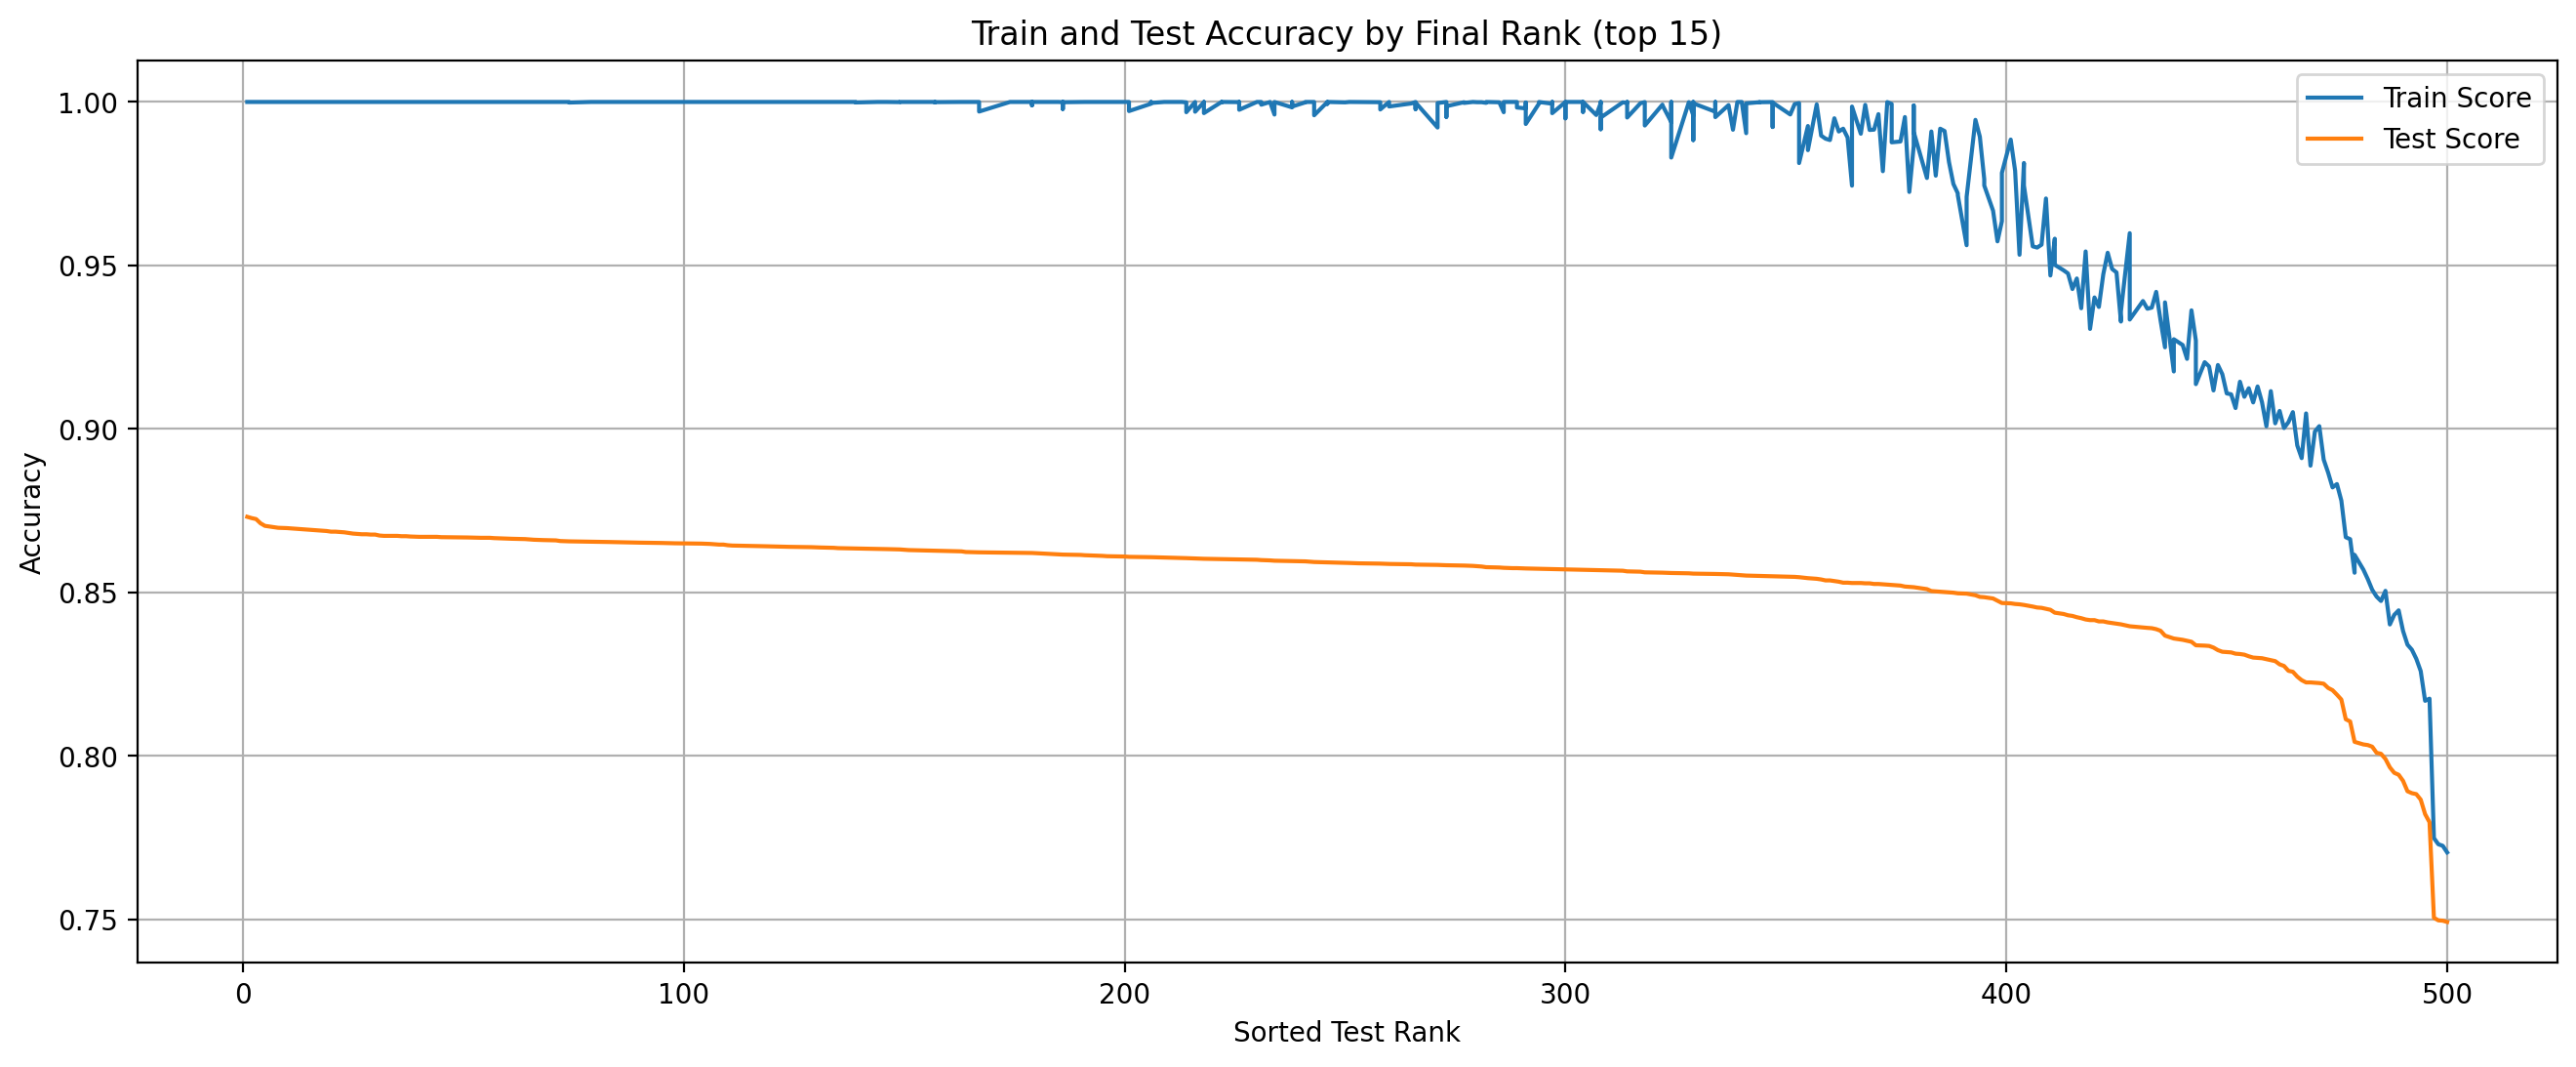

In [11]:
plt.figure(figsize=(16, 6))    

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Test Score")

plt.grid()
plt.xlabel('Sorted Test Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank (top 15)')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

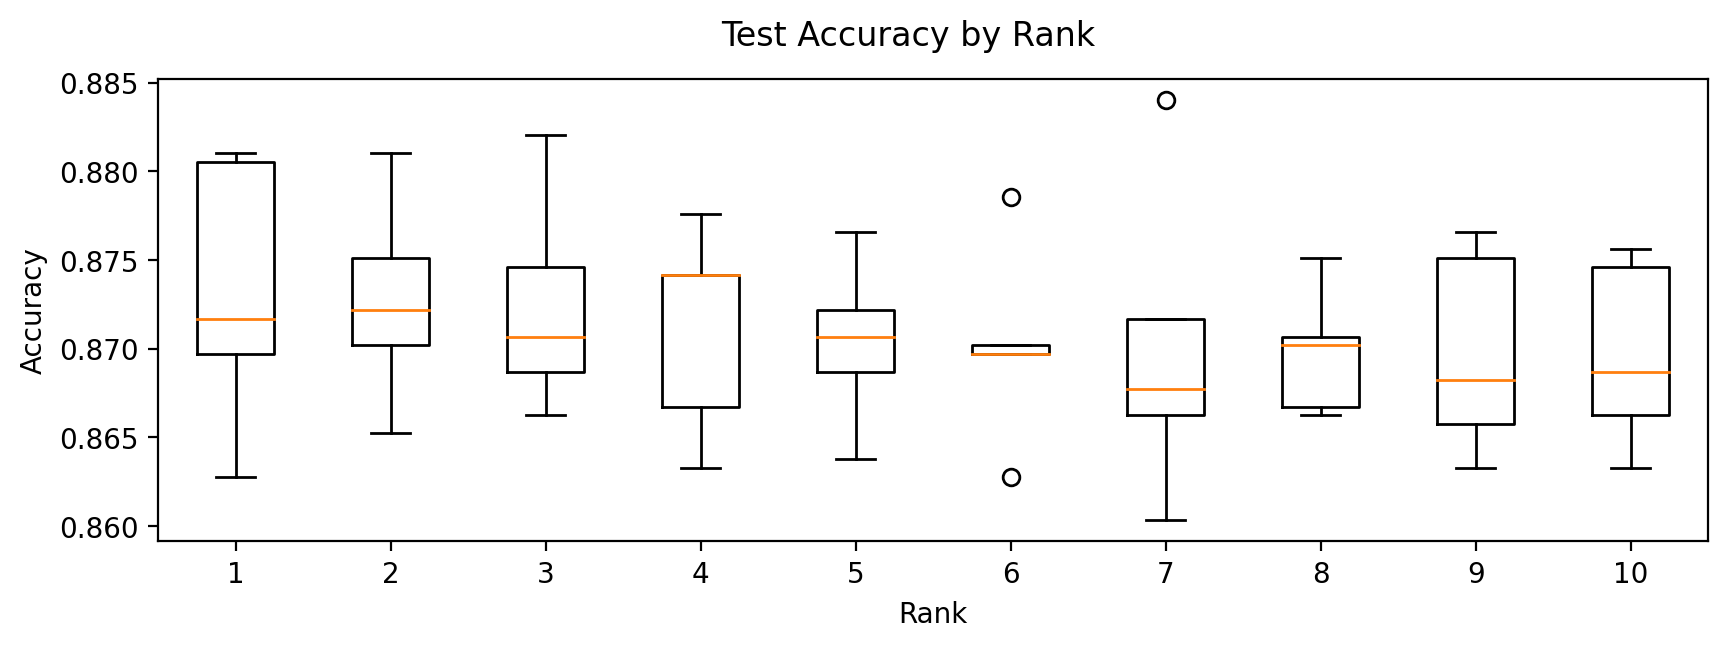

In [12]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

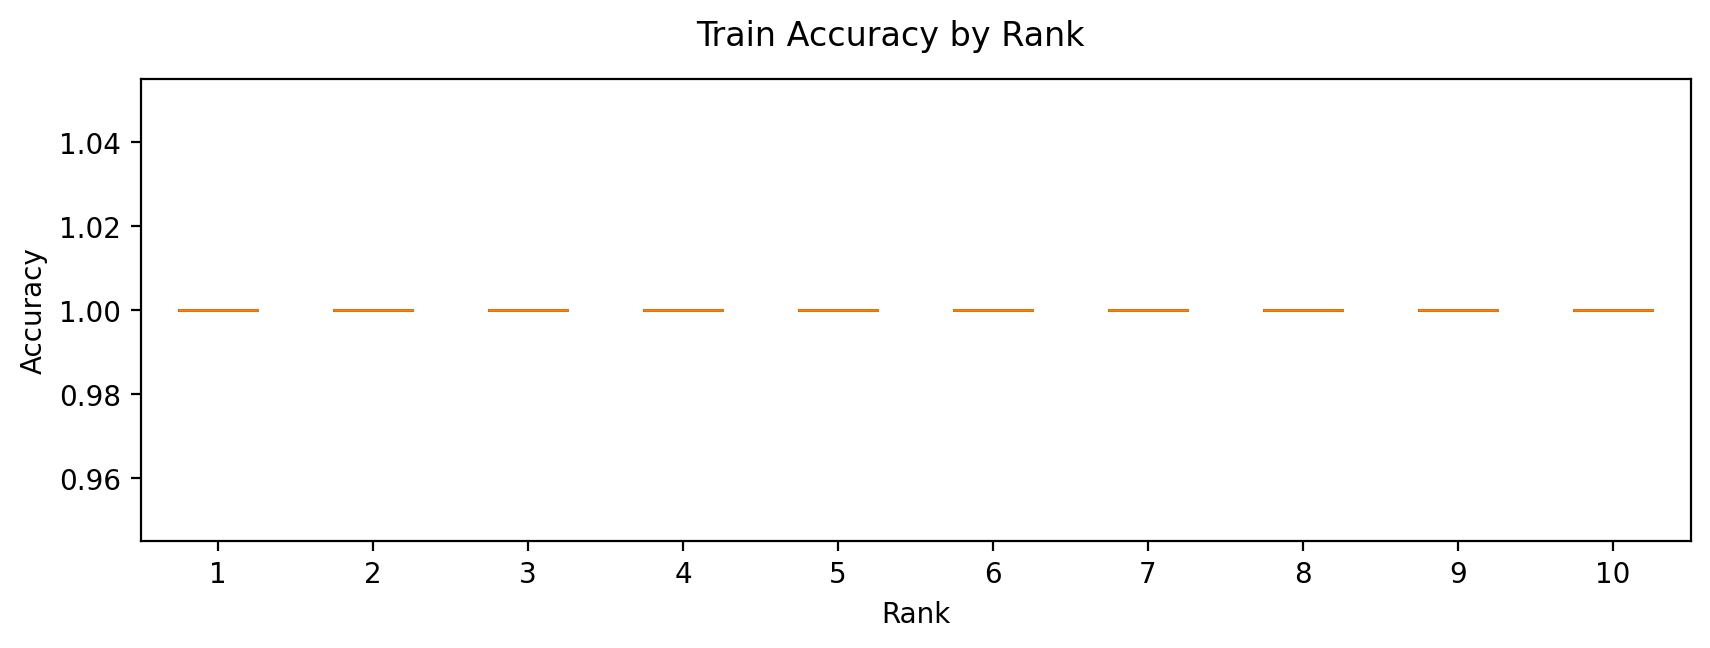

In [13]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [14]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [15]:
print(f"Mean Train set, Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, Accuracy = 1.00
Mean Test  set, Accuracy = 0.87


In [16]:
random_search = pickle.load(open(os.path.join(f"./tuning_results/tuning_lgbm/{timestamp}", file_name), "rb"))
model = random_search.best_estimator_

#model = LGBMClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

In [17]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

Train set, Accuracy = 1.00
Test set, Accuracy = 0.88


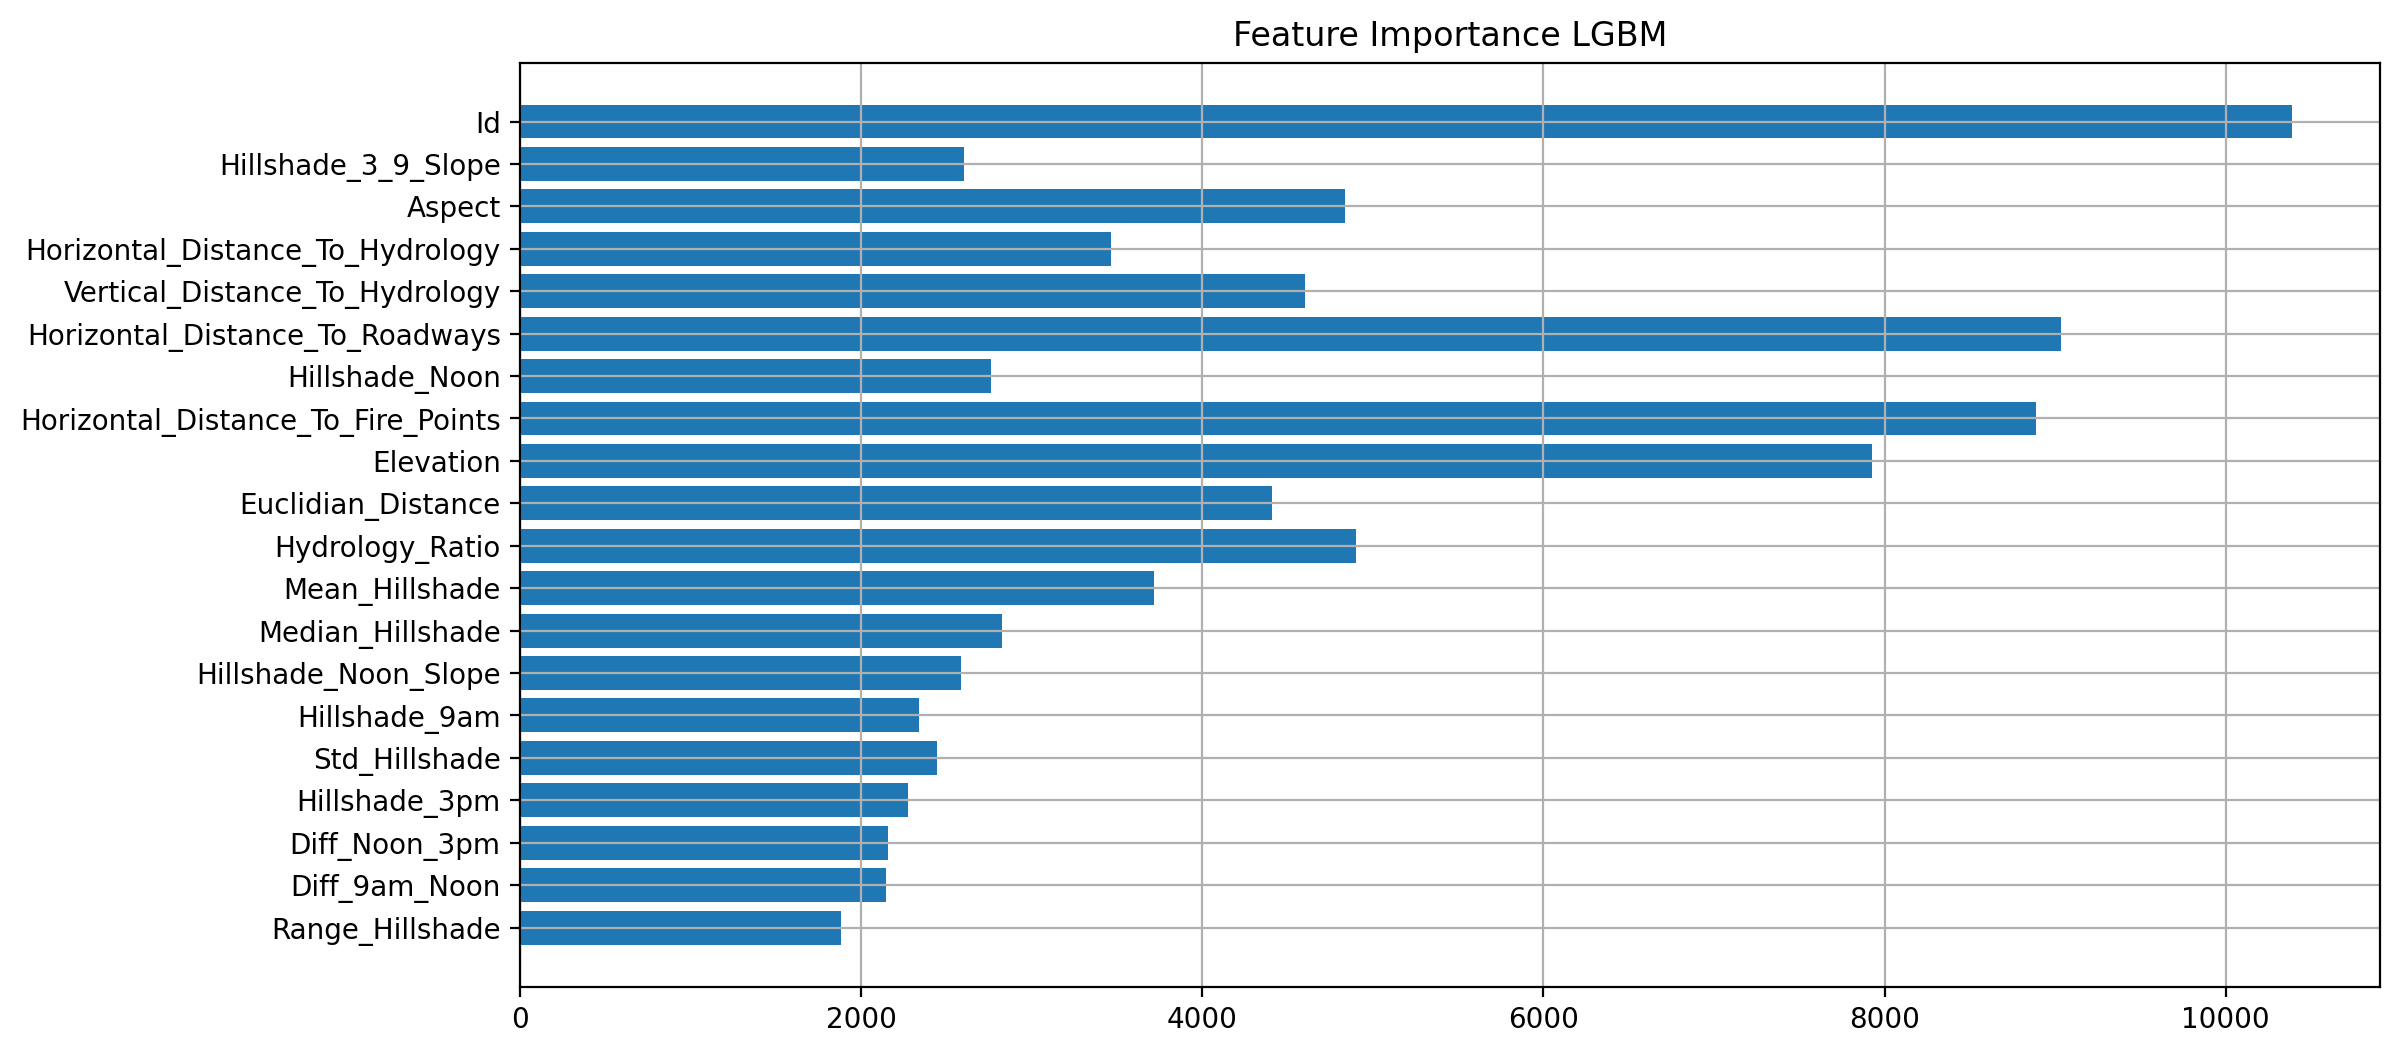

In [18]:
ind = np.argpartition(model.feature_importances_, -20)[-20:]

features = X.columns[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance LGBM')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()

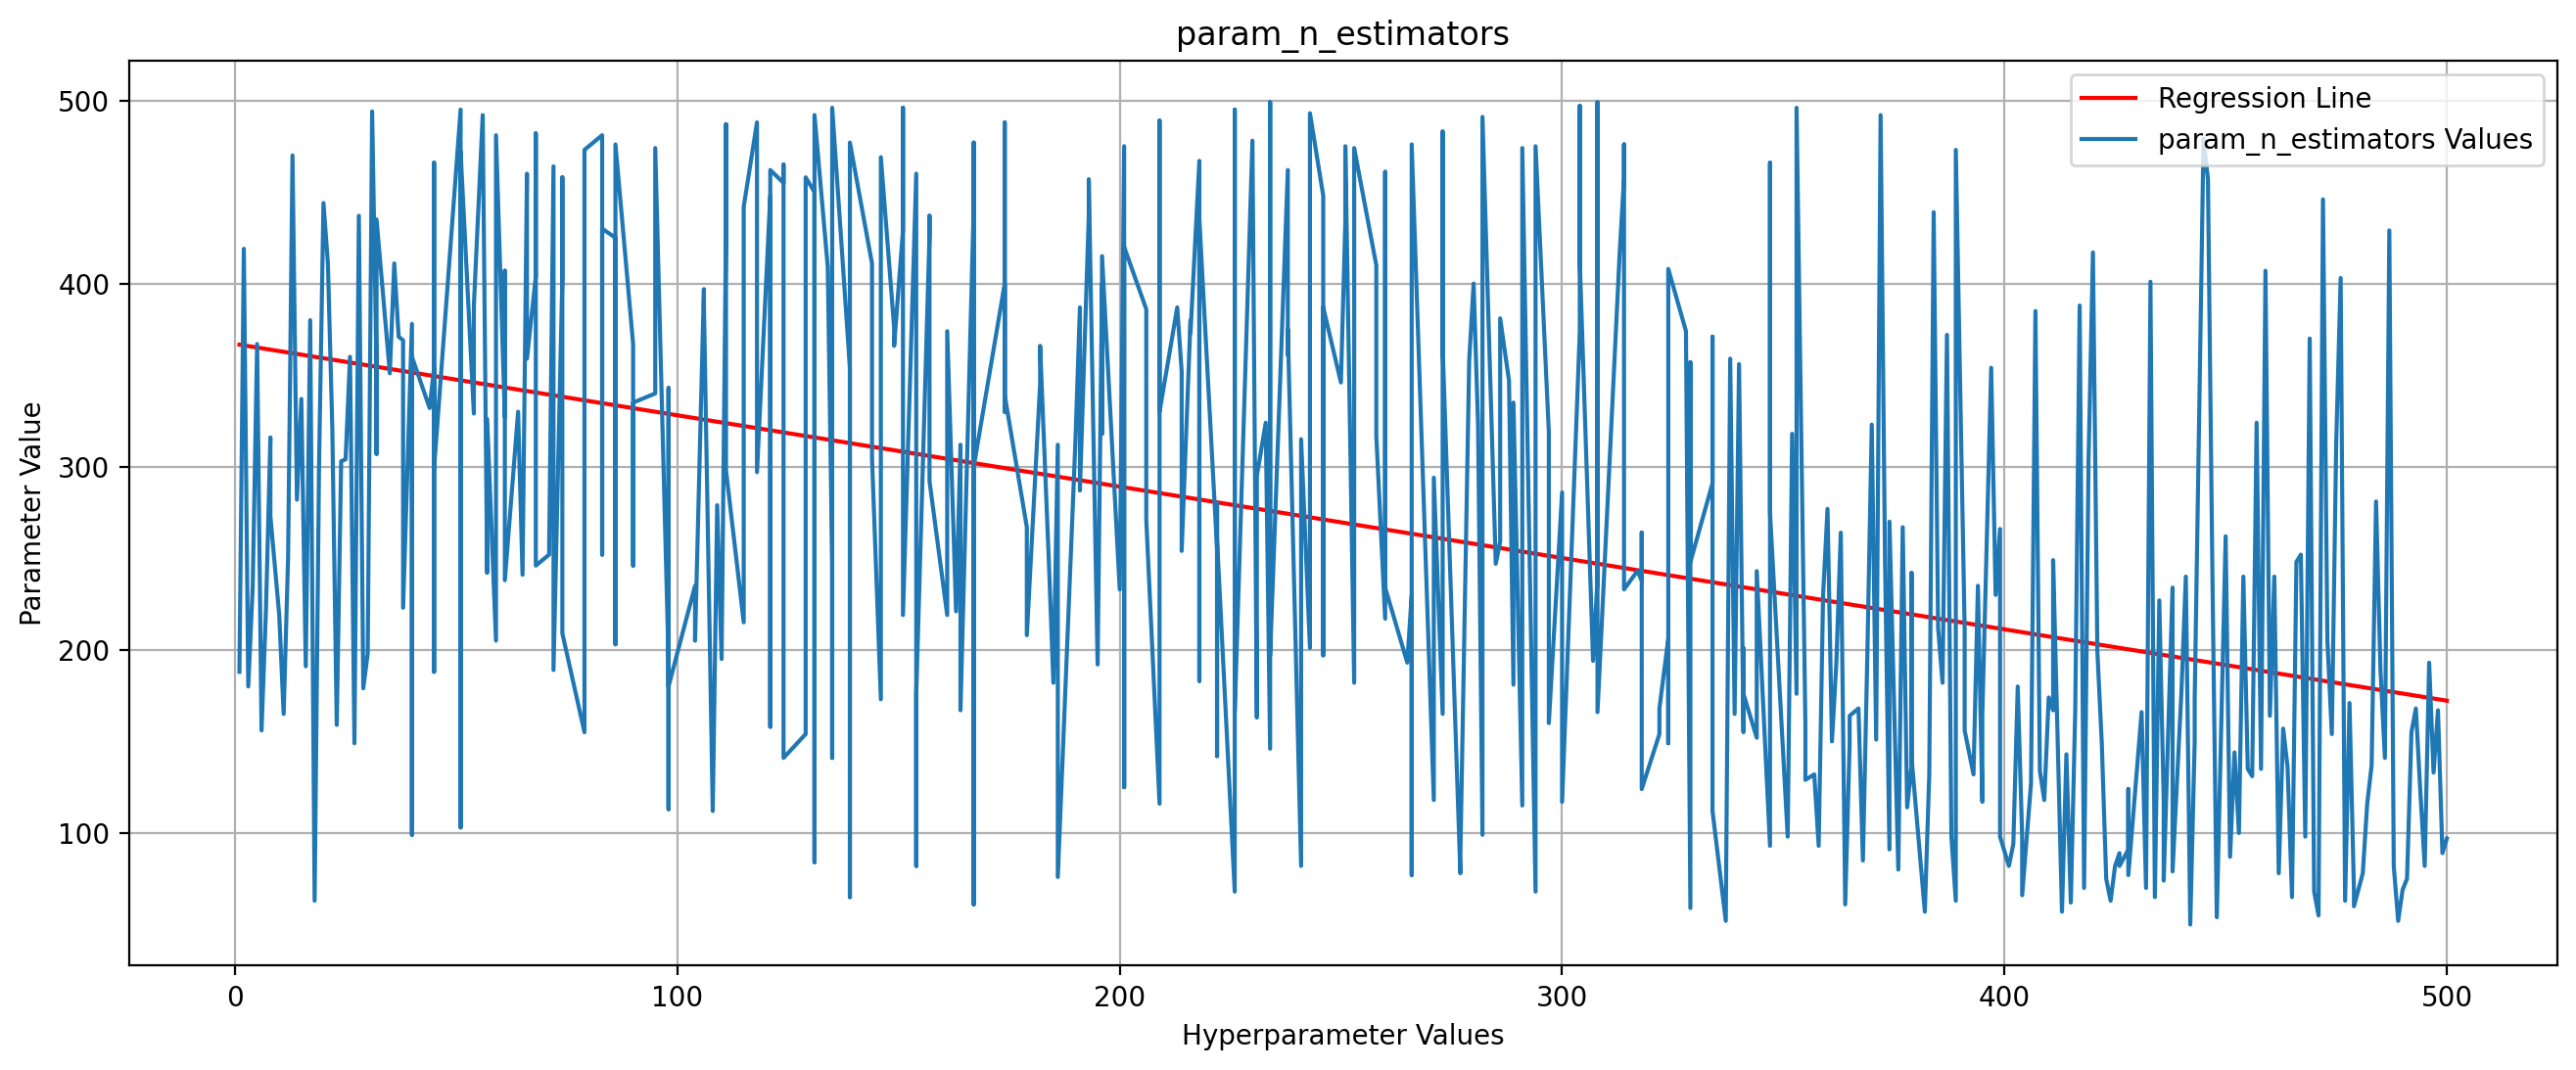

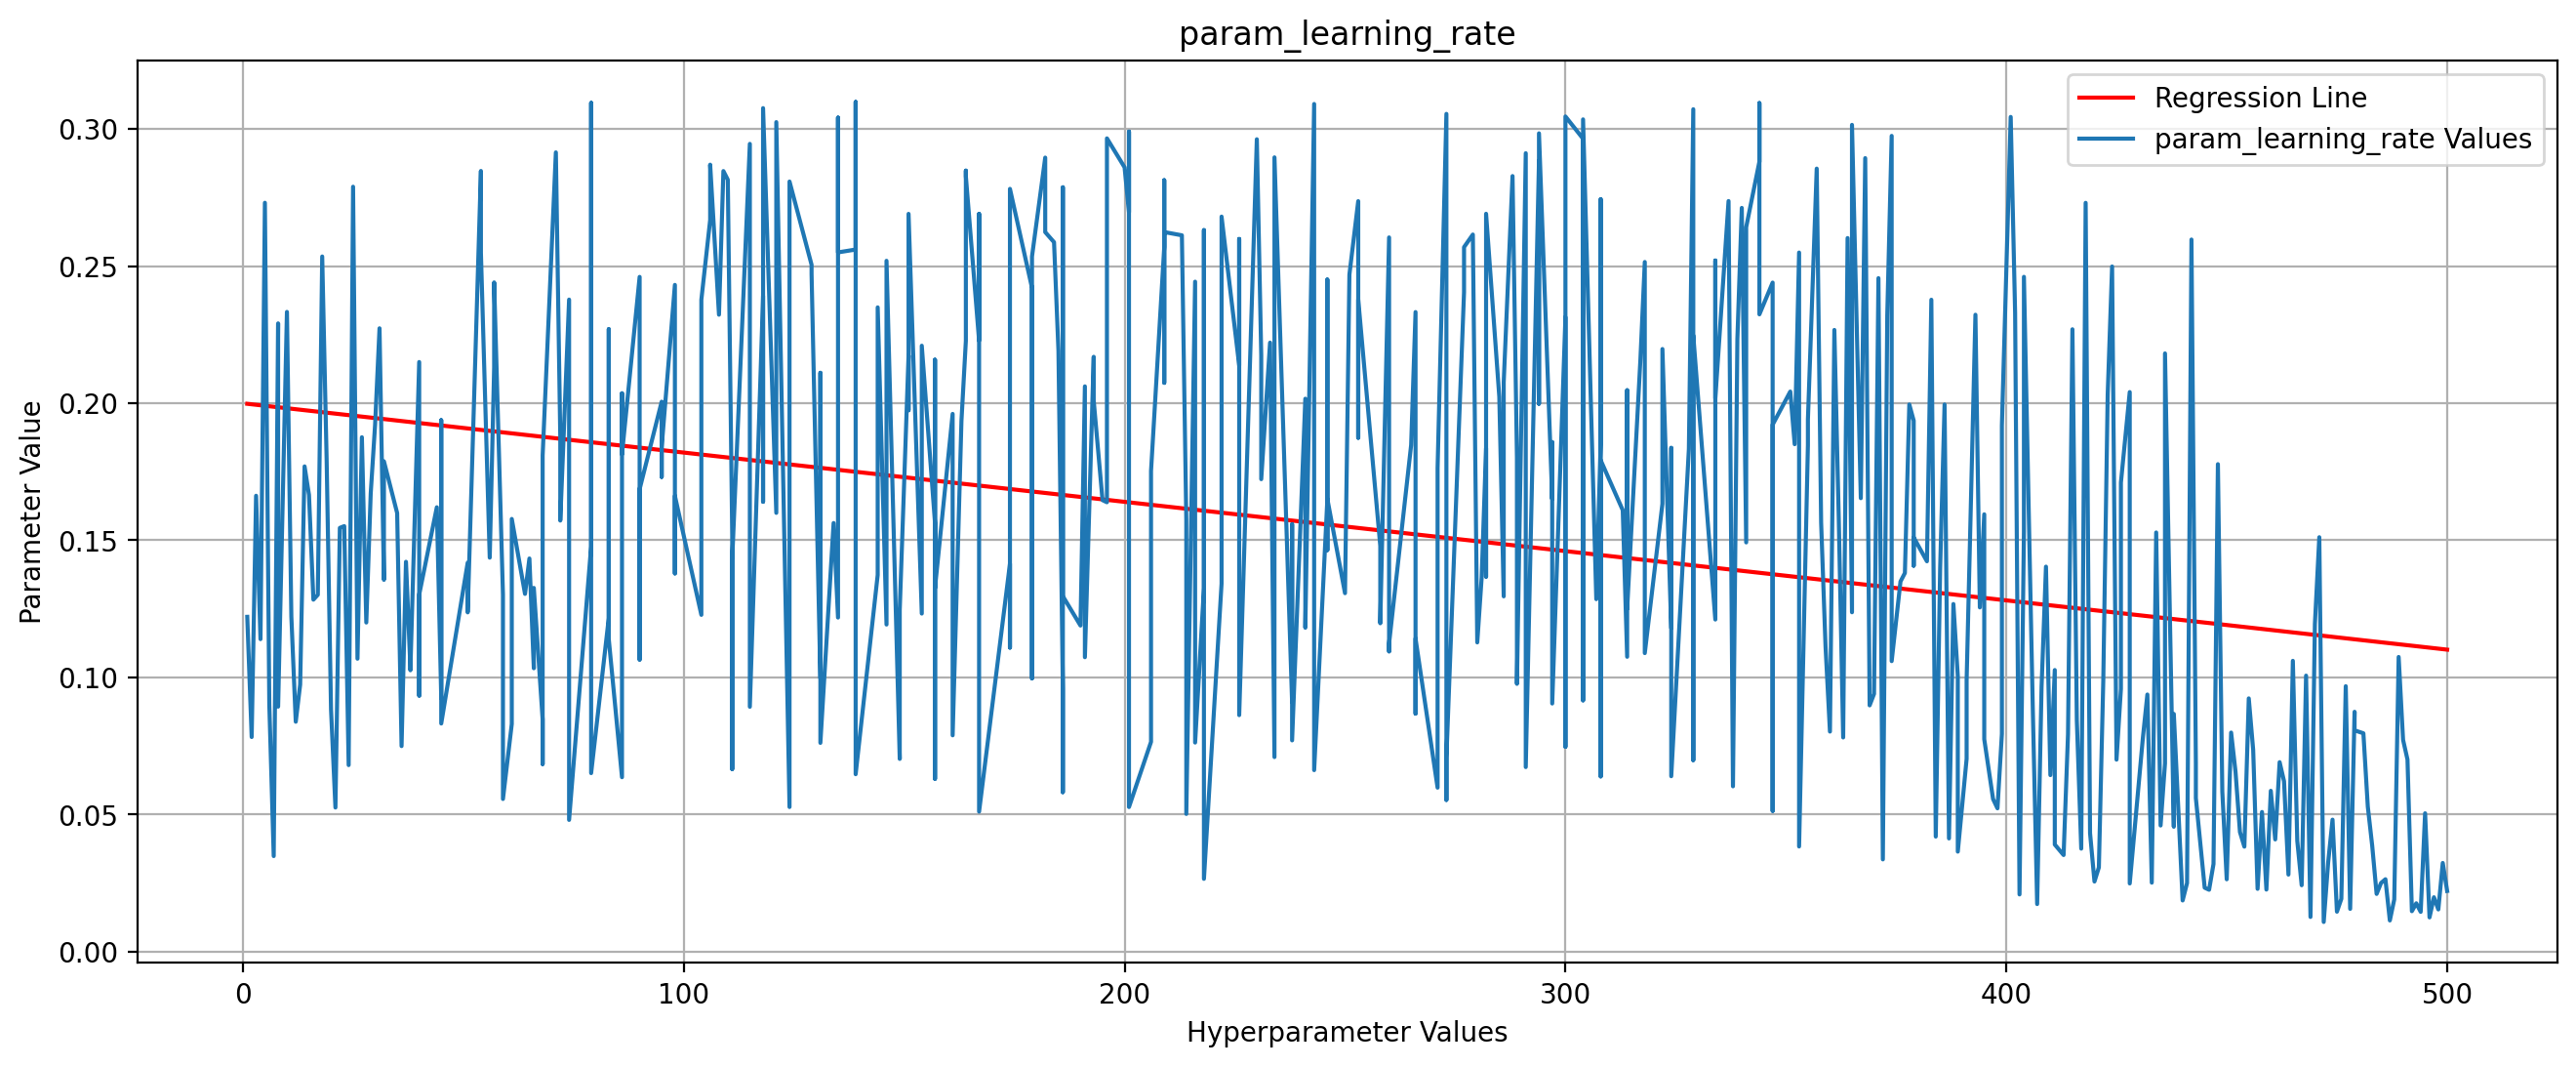

In [19]:
# TEST
for col in ['param_n_estimators', 'param_learning_rate']:
    
    plt.figure(figsize=(16, 6))    

    m, b = np.polyfit(list(sorted_cv['rank_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['rank_test_score'], m * sorted_cv['rank_test_score'] + b, c='r', label="Regression Line")
    plt.plot(sorted_cv['rank_test_score'], sorted_cv[col], label=f"{col} Values")
    
    plt.grid()
    plt.xlabel('Hyperparameter Values')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')

    
    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))
                  
    plt.show()


# Hyperparameter Evaluation

In [20]:

def plot_parameters(x_values, title):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r')
    
    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)
    
    
    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))
            
    plt.show()



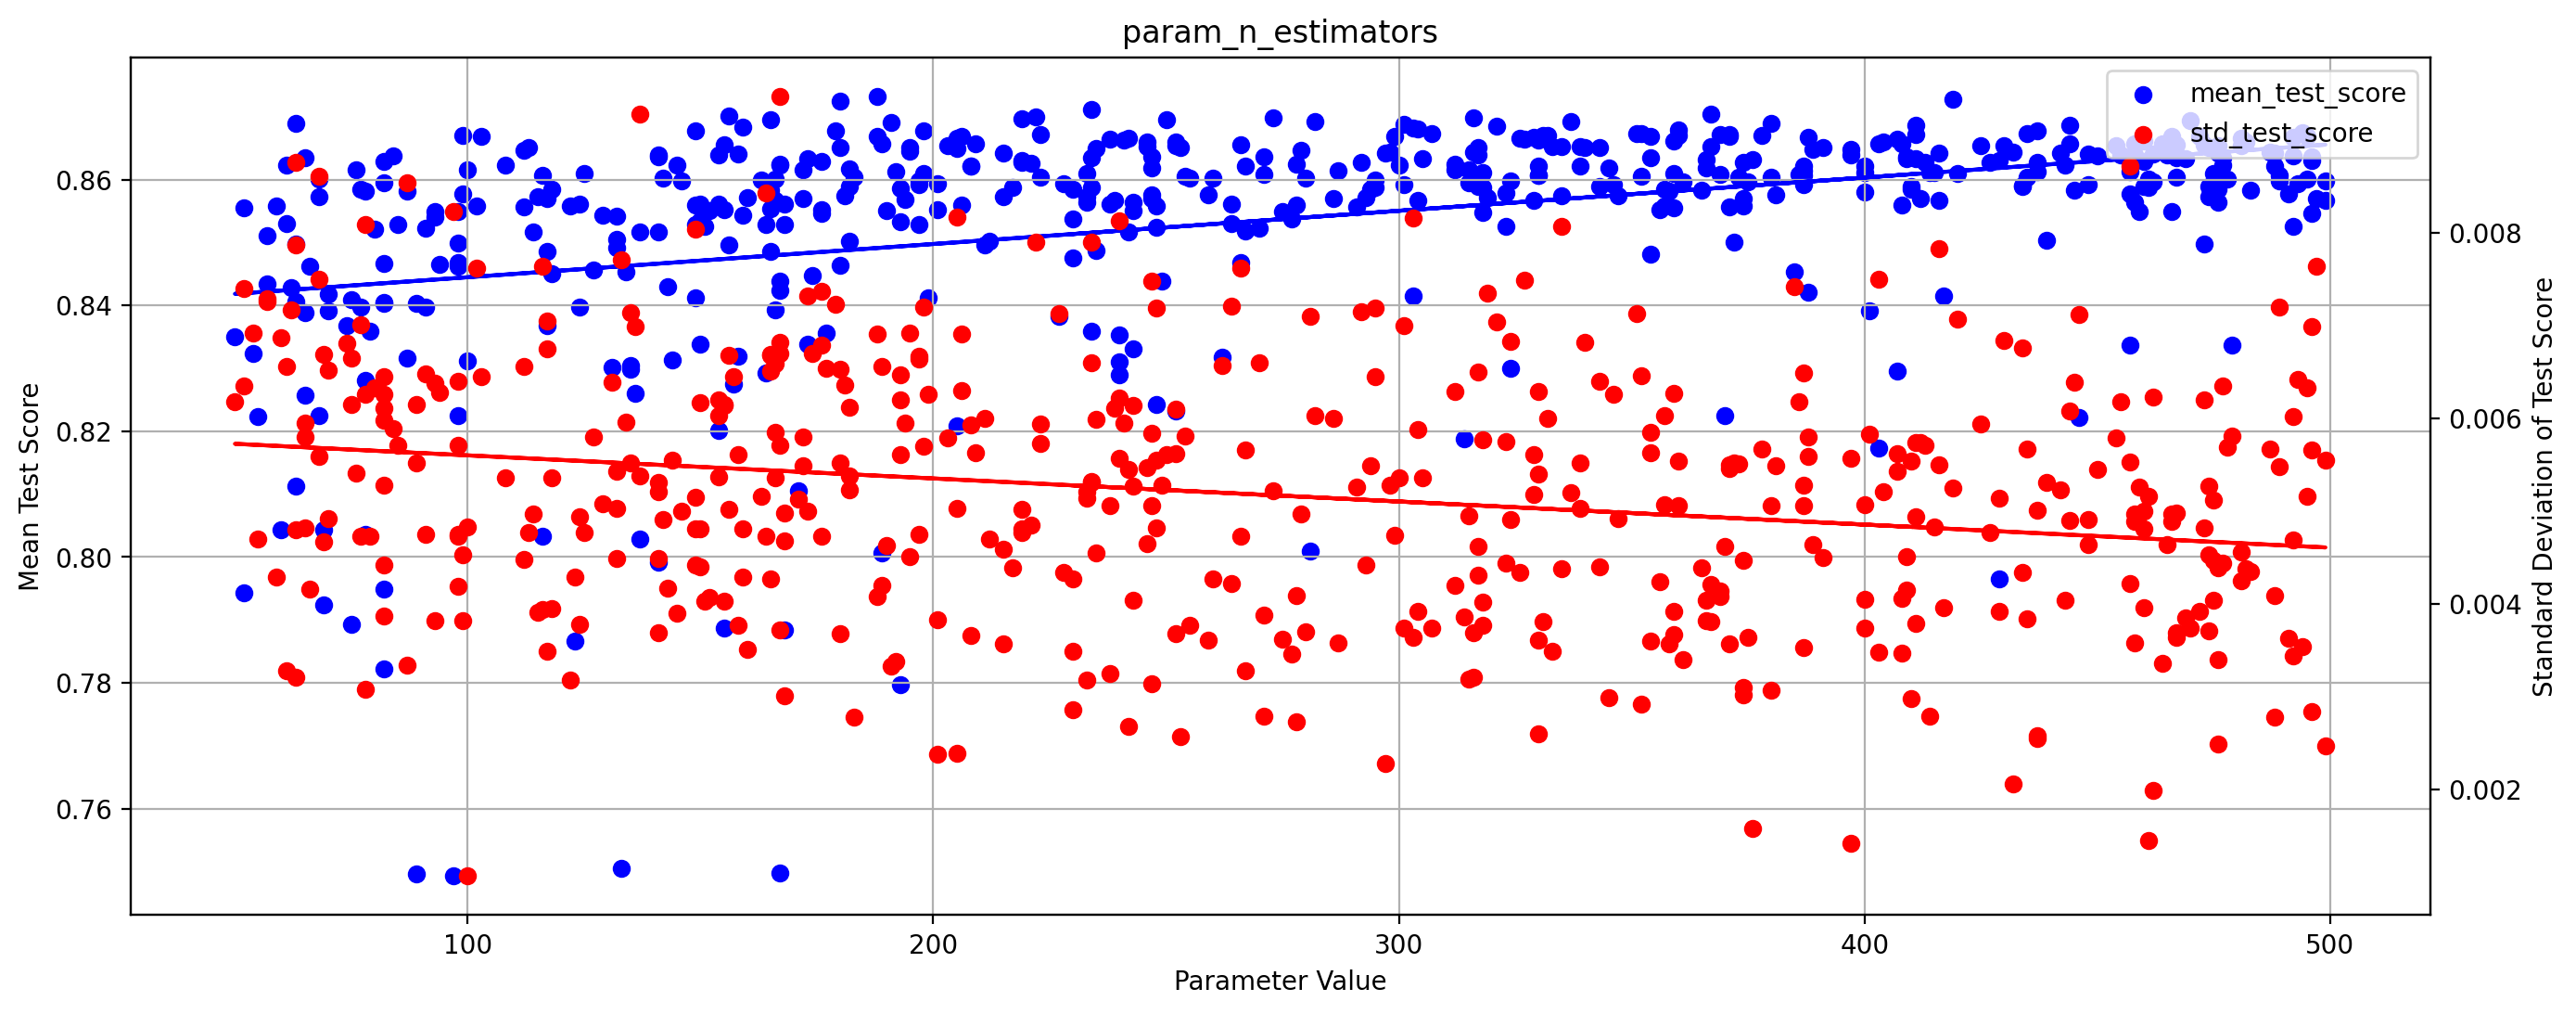

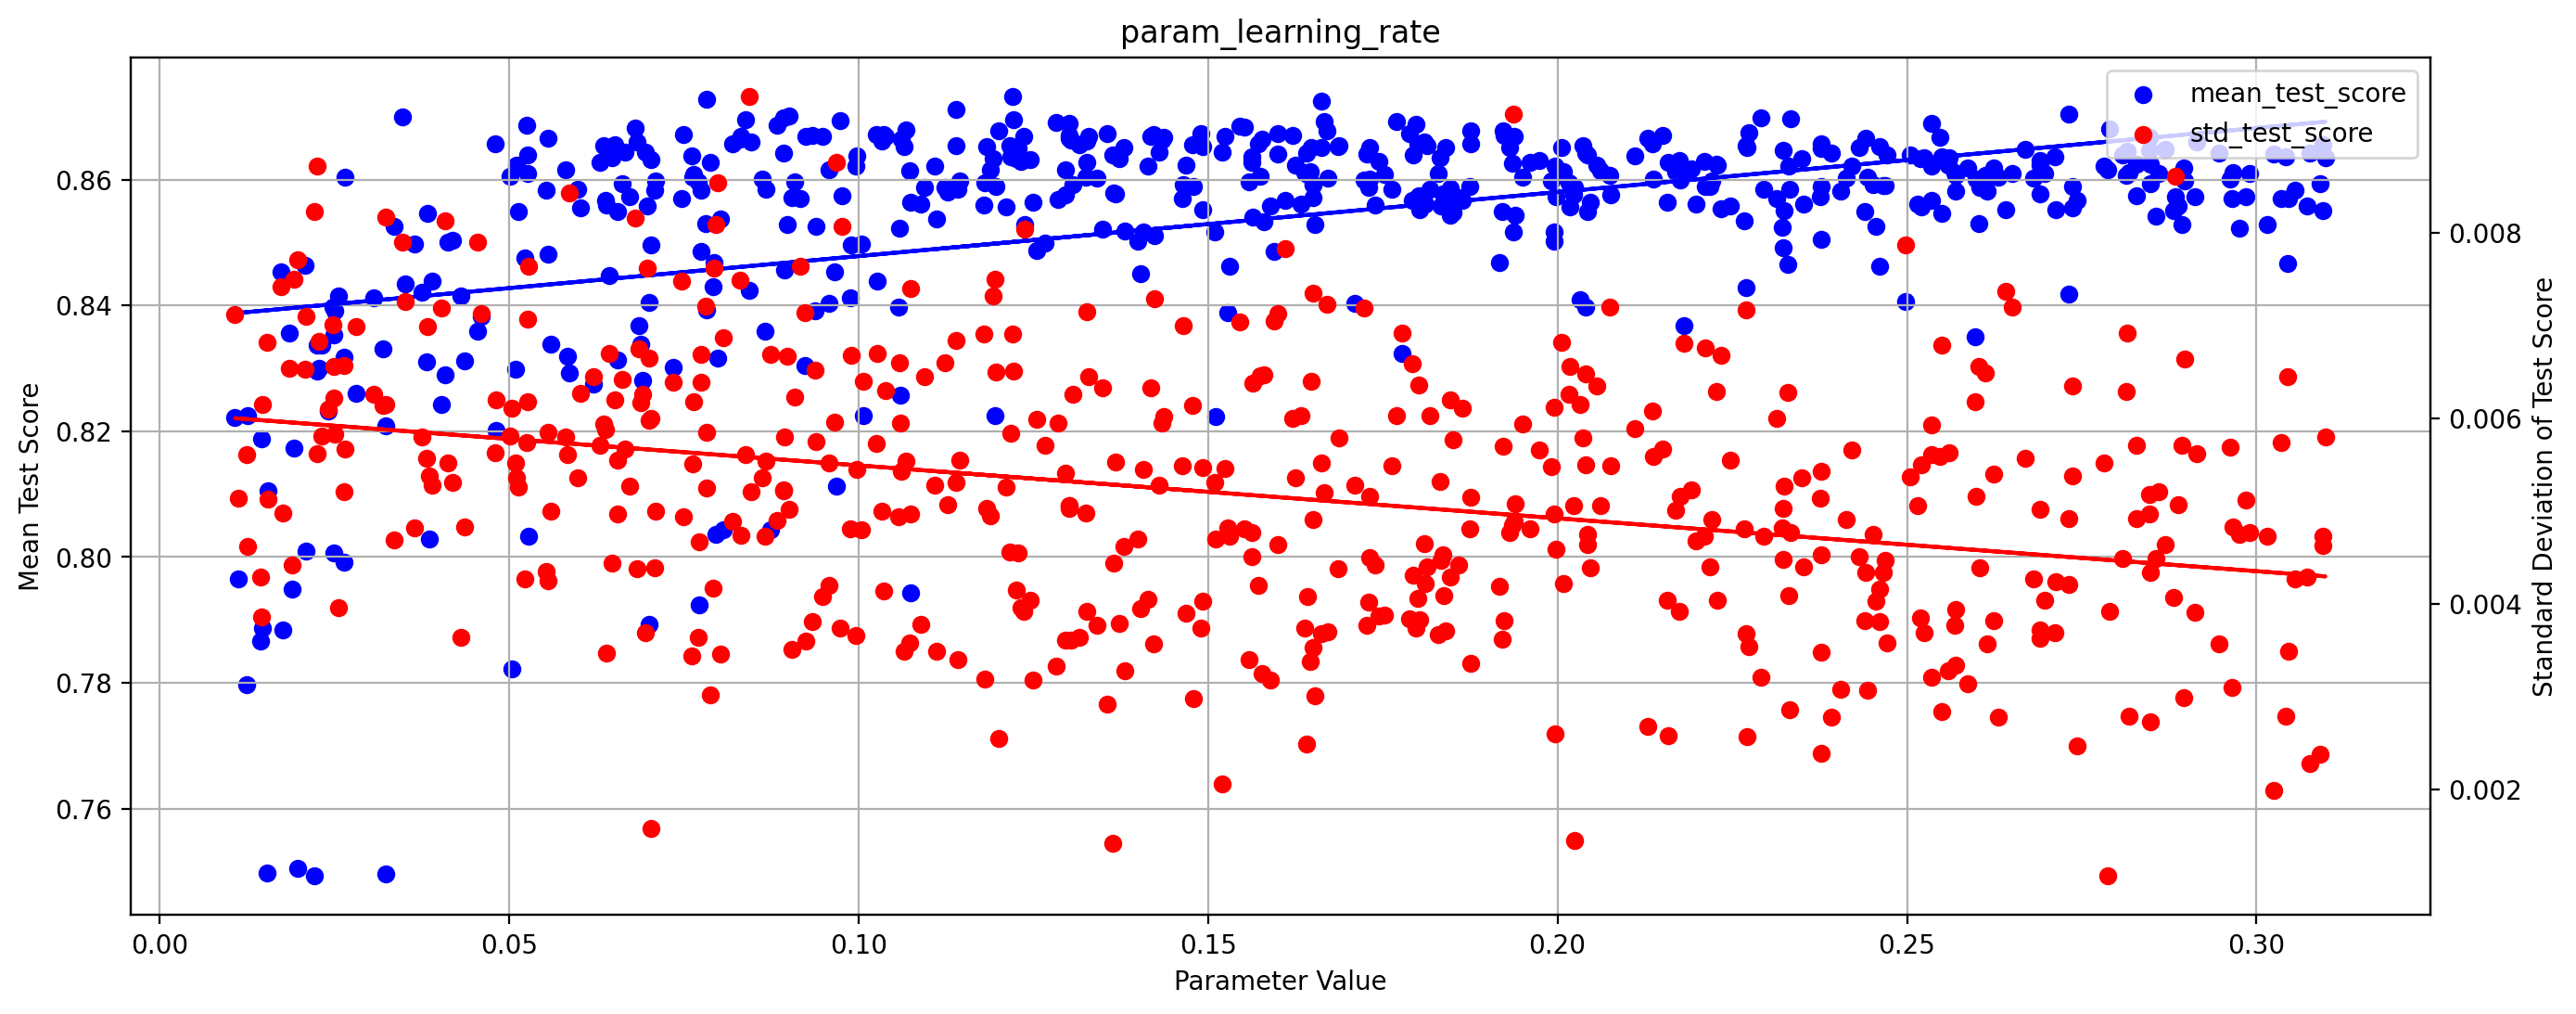

In [21]:

for param in ['param_n_estimators', 'param_learning_rate']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


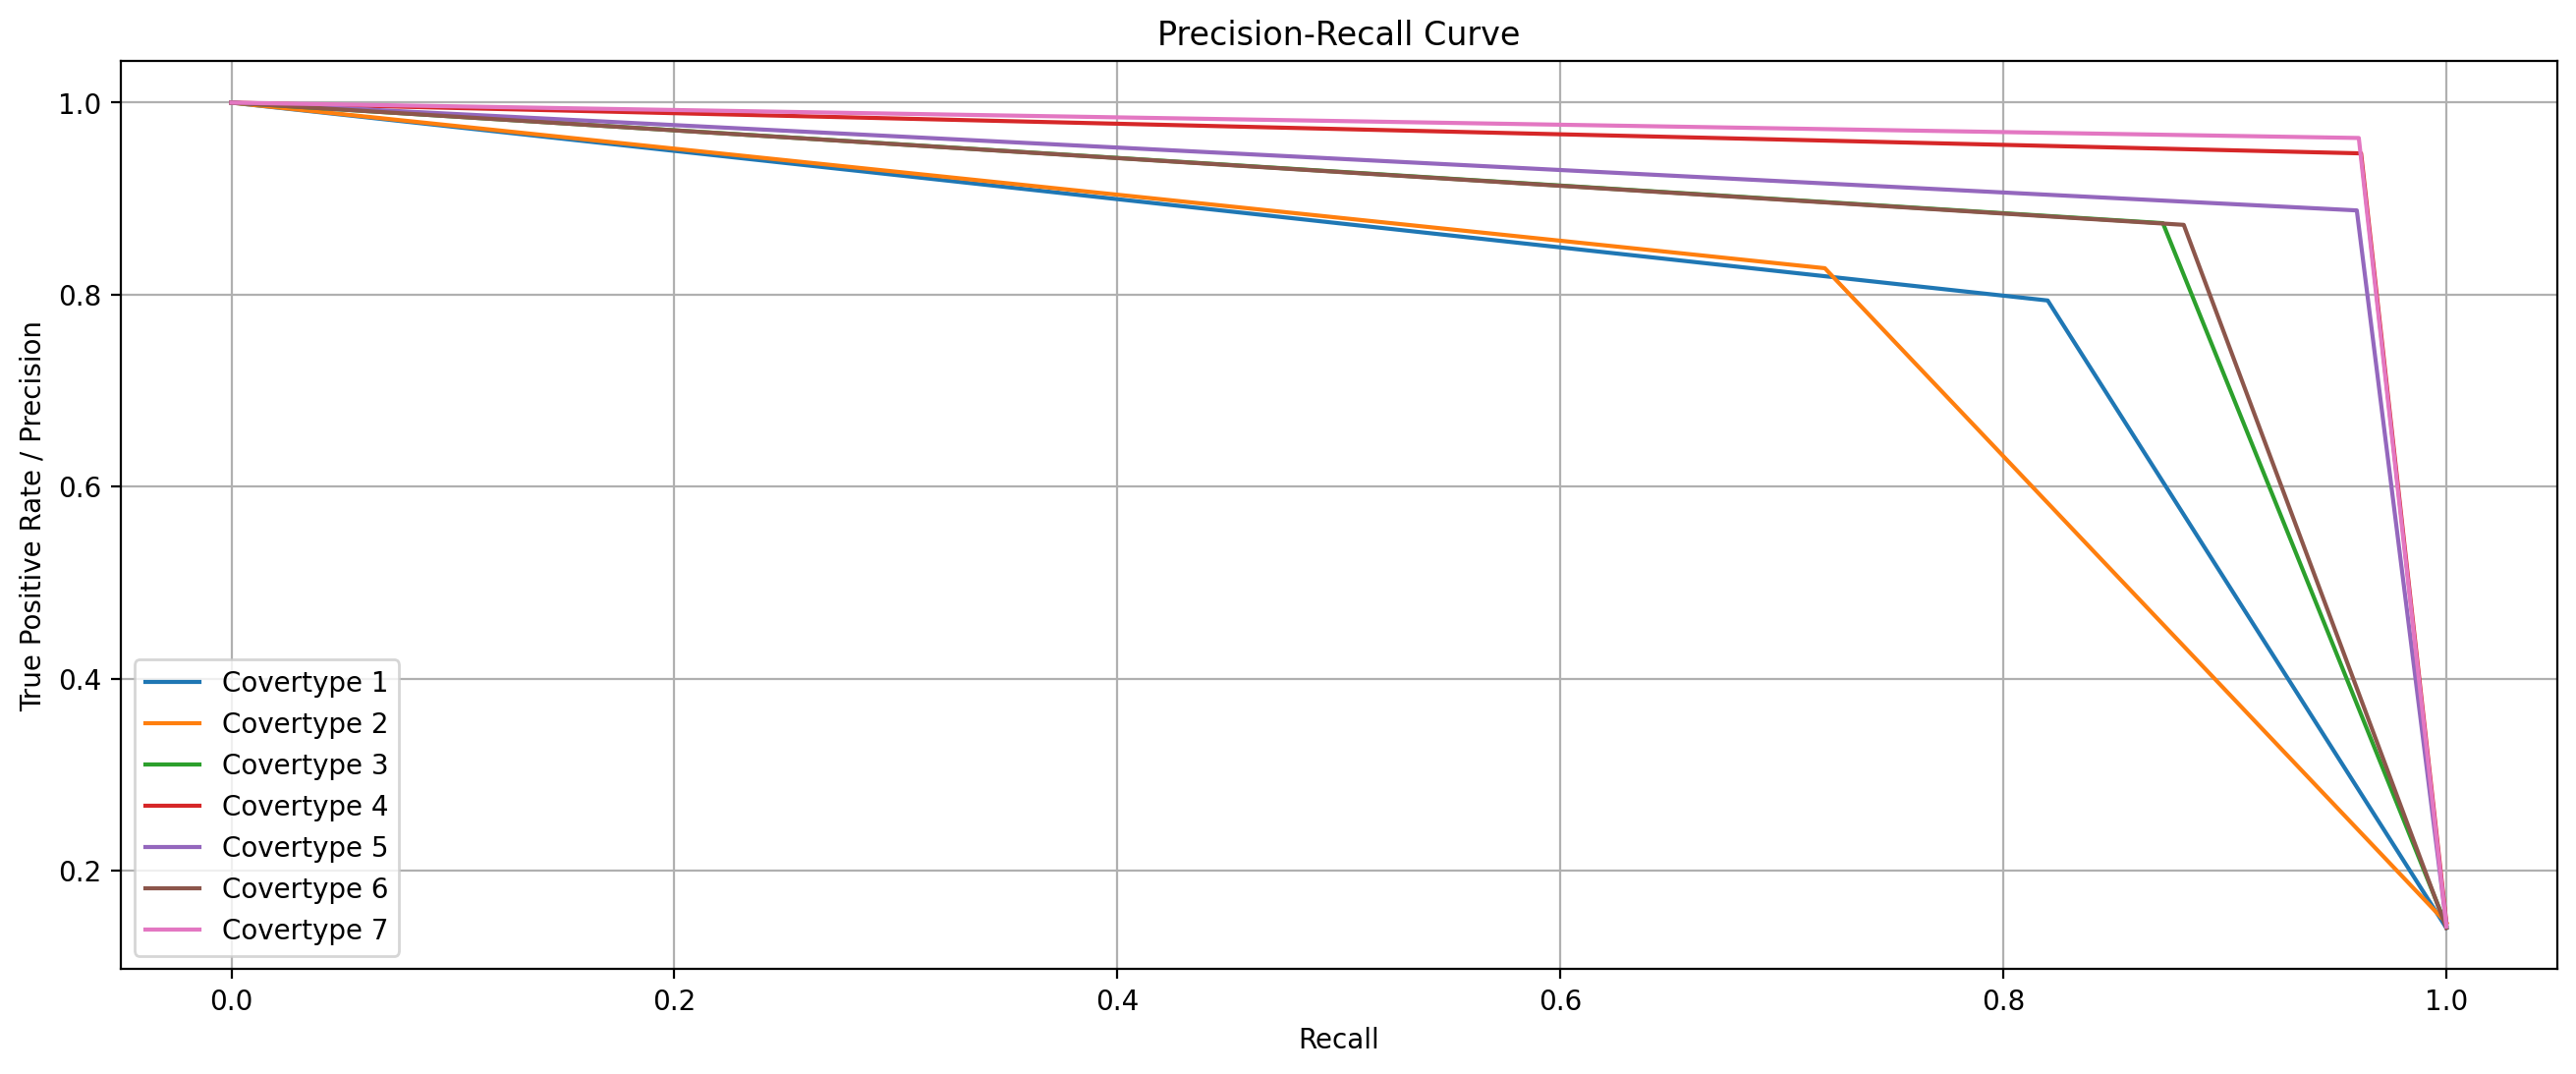

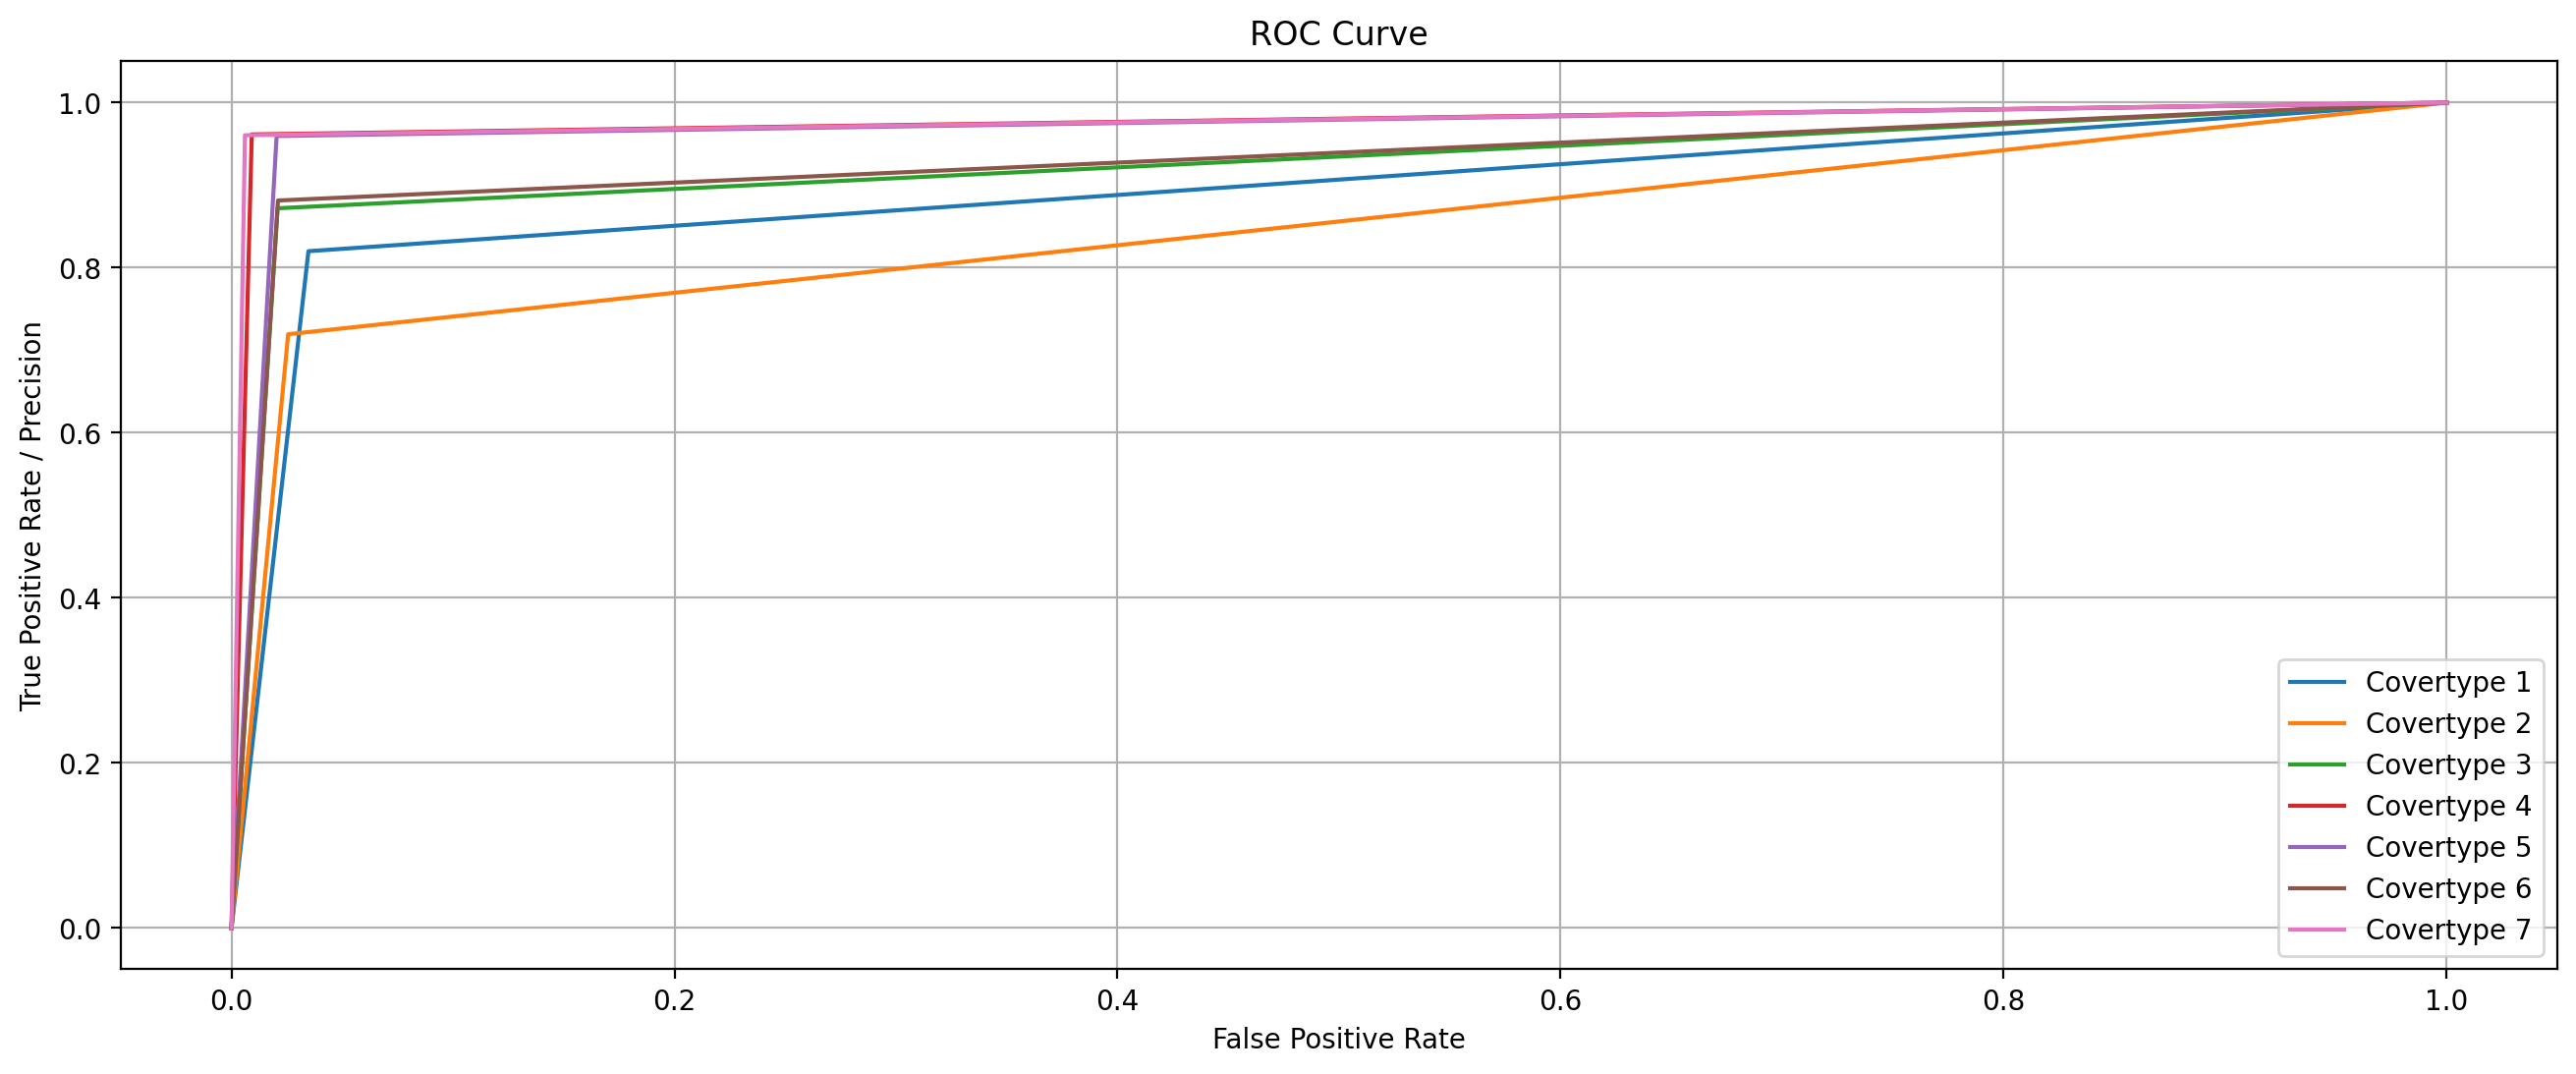

In [22]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score_bin = label_binarize(y_test_prediction, classes=np.unique(y_test_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))    
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))    
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')
            
filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Partial Dependence

In [23]:
# potentially iterate over features (and relation ie 0 to 1)

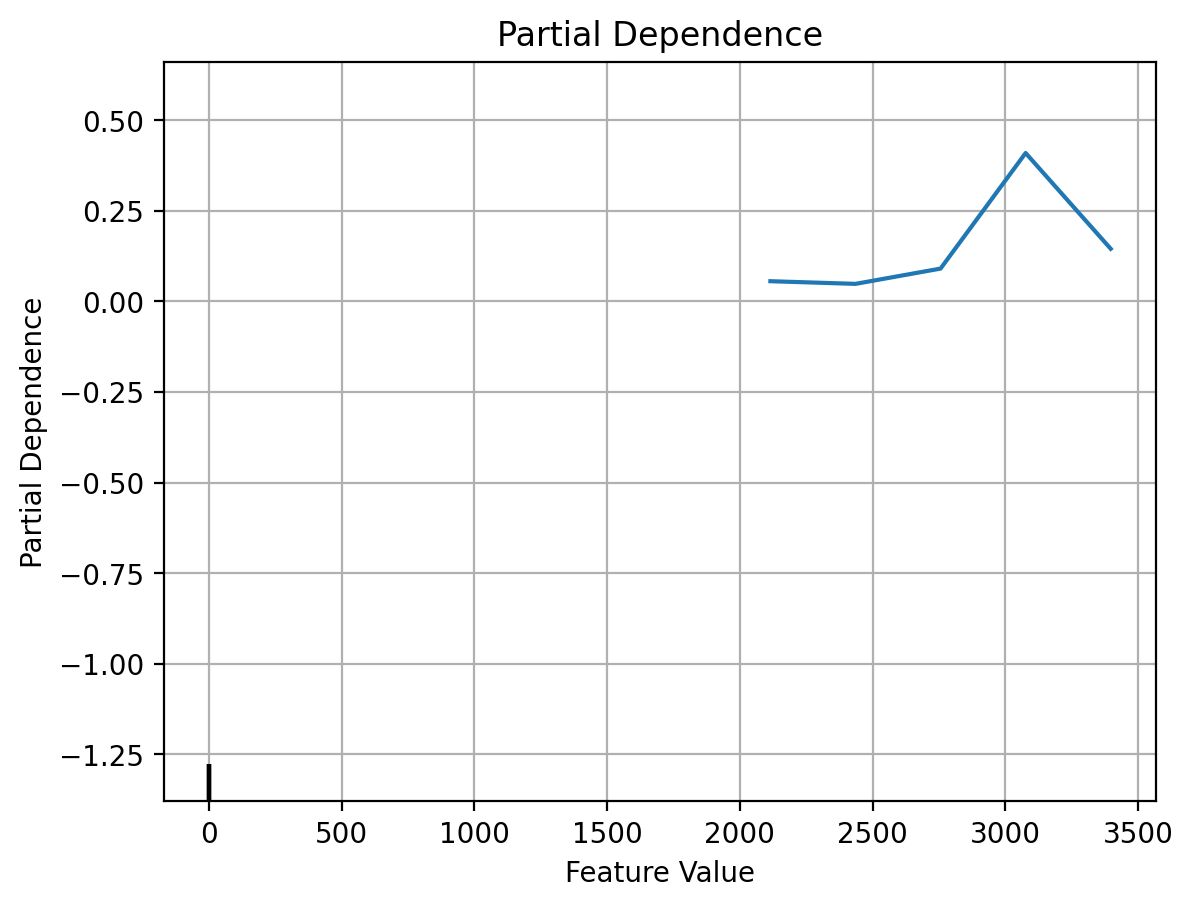

In [24]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence') 
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Confusion Matrix

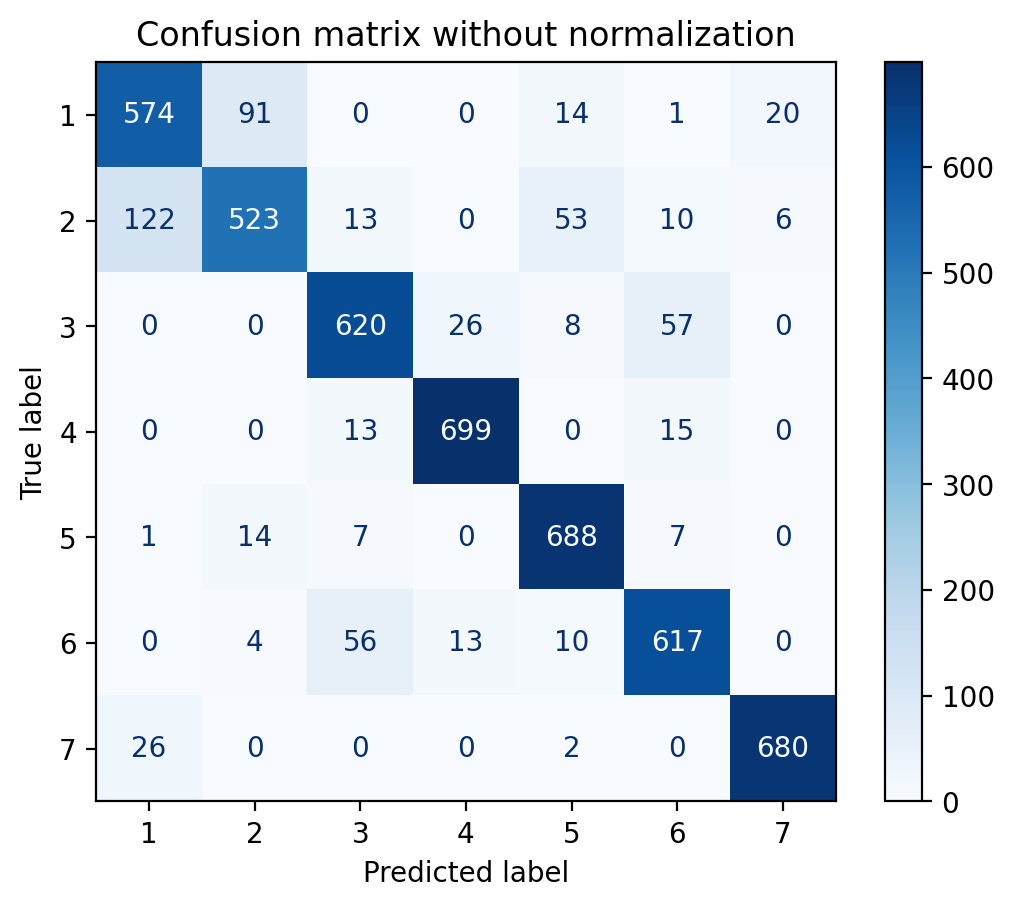

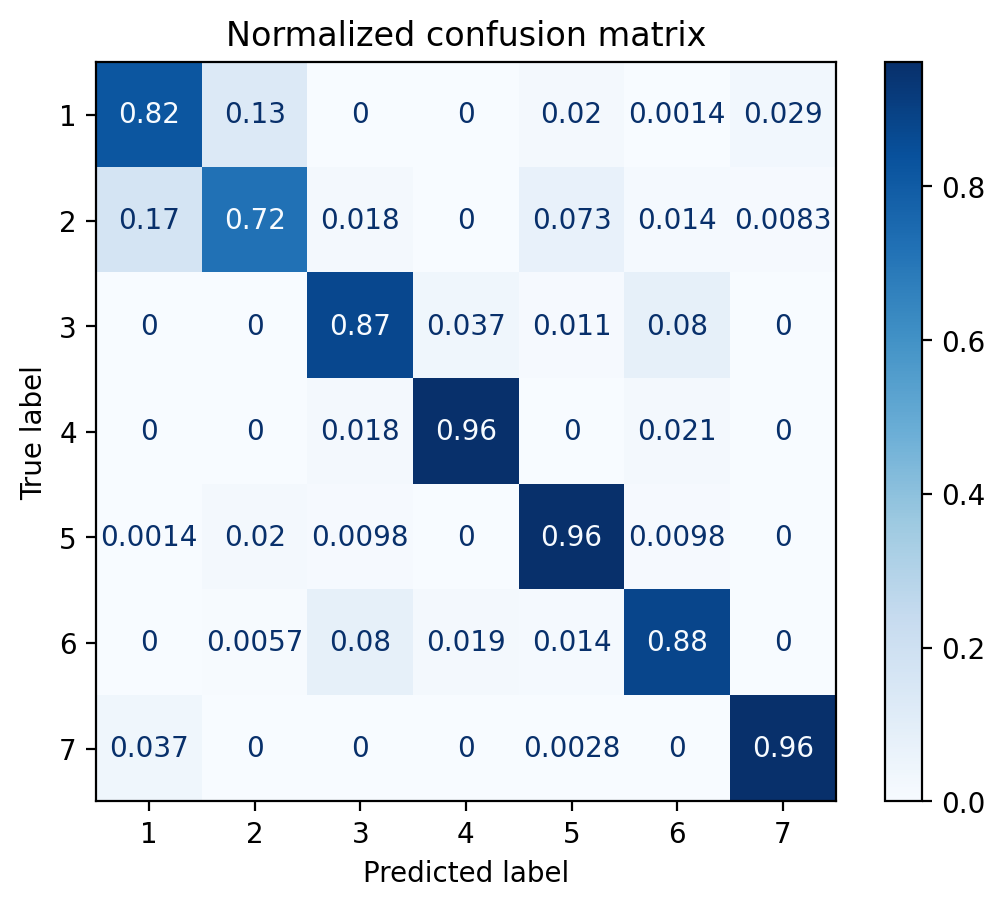

In [25]:

class_names = np.unique(y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [26]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_test, check_additivity=False)


In [27]:
shap.summary_plot(explanation, X_test, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()  

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.
